<a href="https://colab.research.google.com/github/shams-mehdi/TERP_tutorial/blob/main/Tutorial_TERP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

######**Tutorial**: Thermodynamics-inspired explanations of artificial intelligence (**TERP**)
**Authors** Shams Mehdi, Pratyush Tiwary  
**Date** Nov 1, 2024  
**Aims**  

Aim of this tutorial is to introduce users to the [Thermodynamics-inspired Explainable Representations of AI and other black-box Paradigms (TERP) ](https://www.nature.com/articles/s41467-024-51970-x) method implemented in Python (3 main scripts) for generating efficient, highly human-interpretable feature importance attribution for any ML model and for a variety of data types. The tutorial was designed for Google Colab but with minor adjustments can be run elsewhere.  

**Objectives**  
1. Core scripts with synthetic data (tabular) + linear model (regressor)
2. MD data (alaine dipeptide in vaccuum) + VAMPnets (classifier)

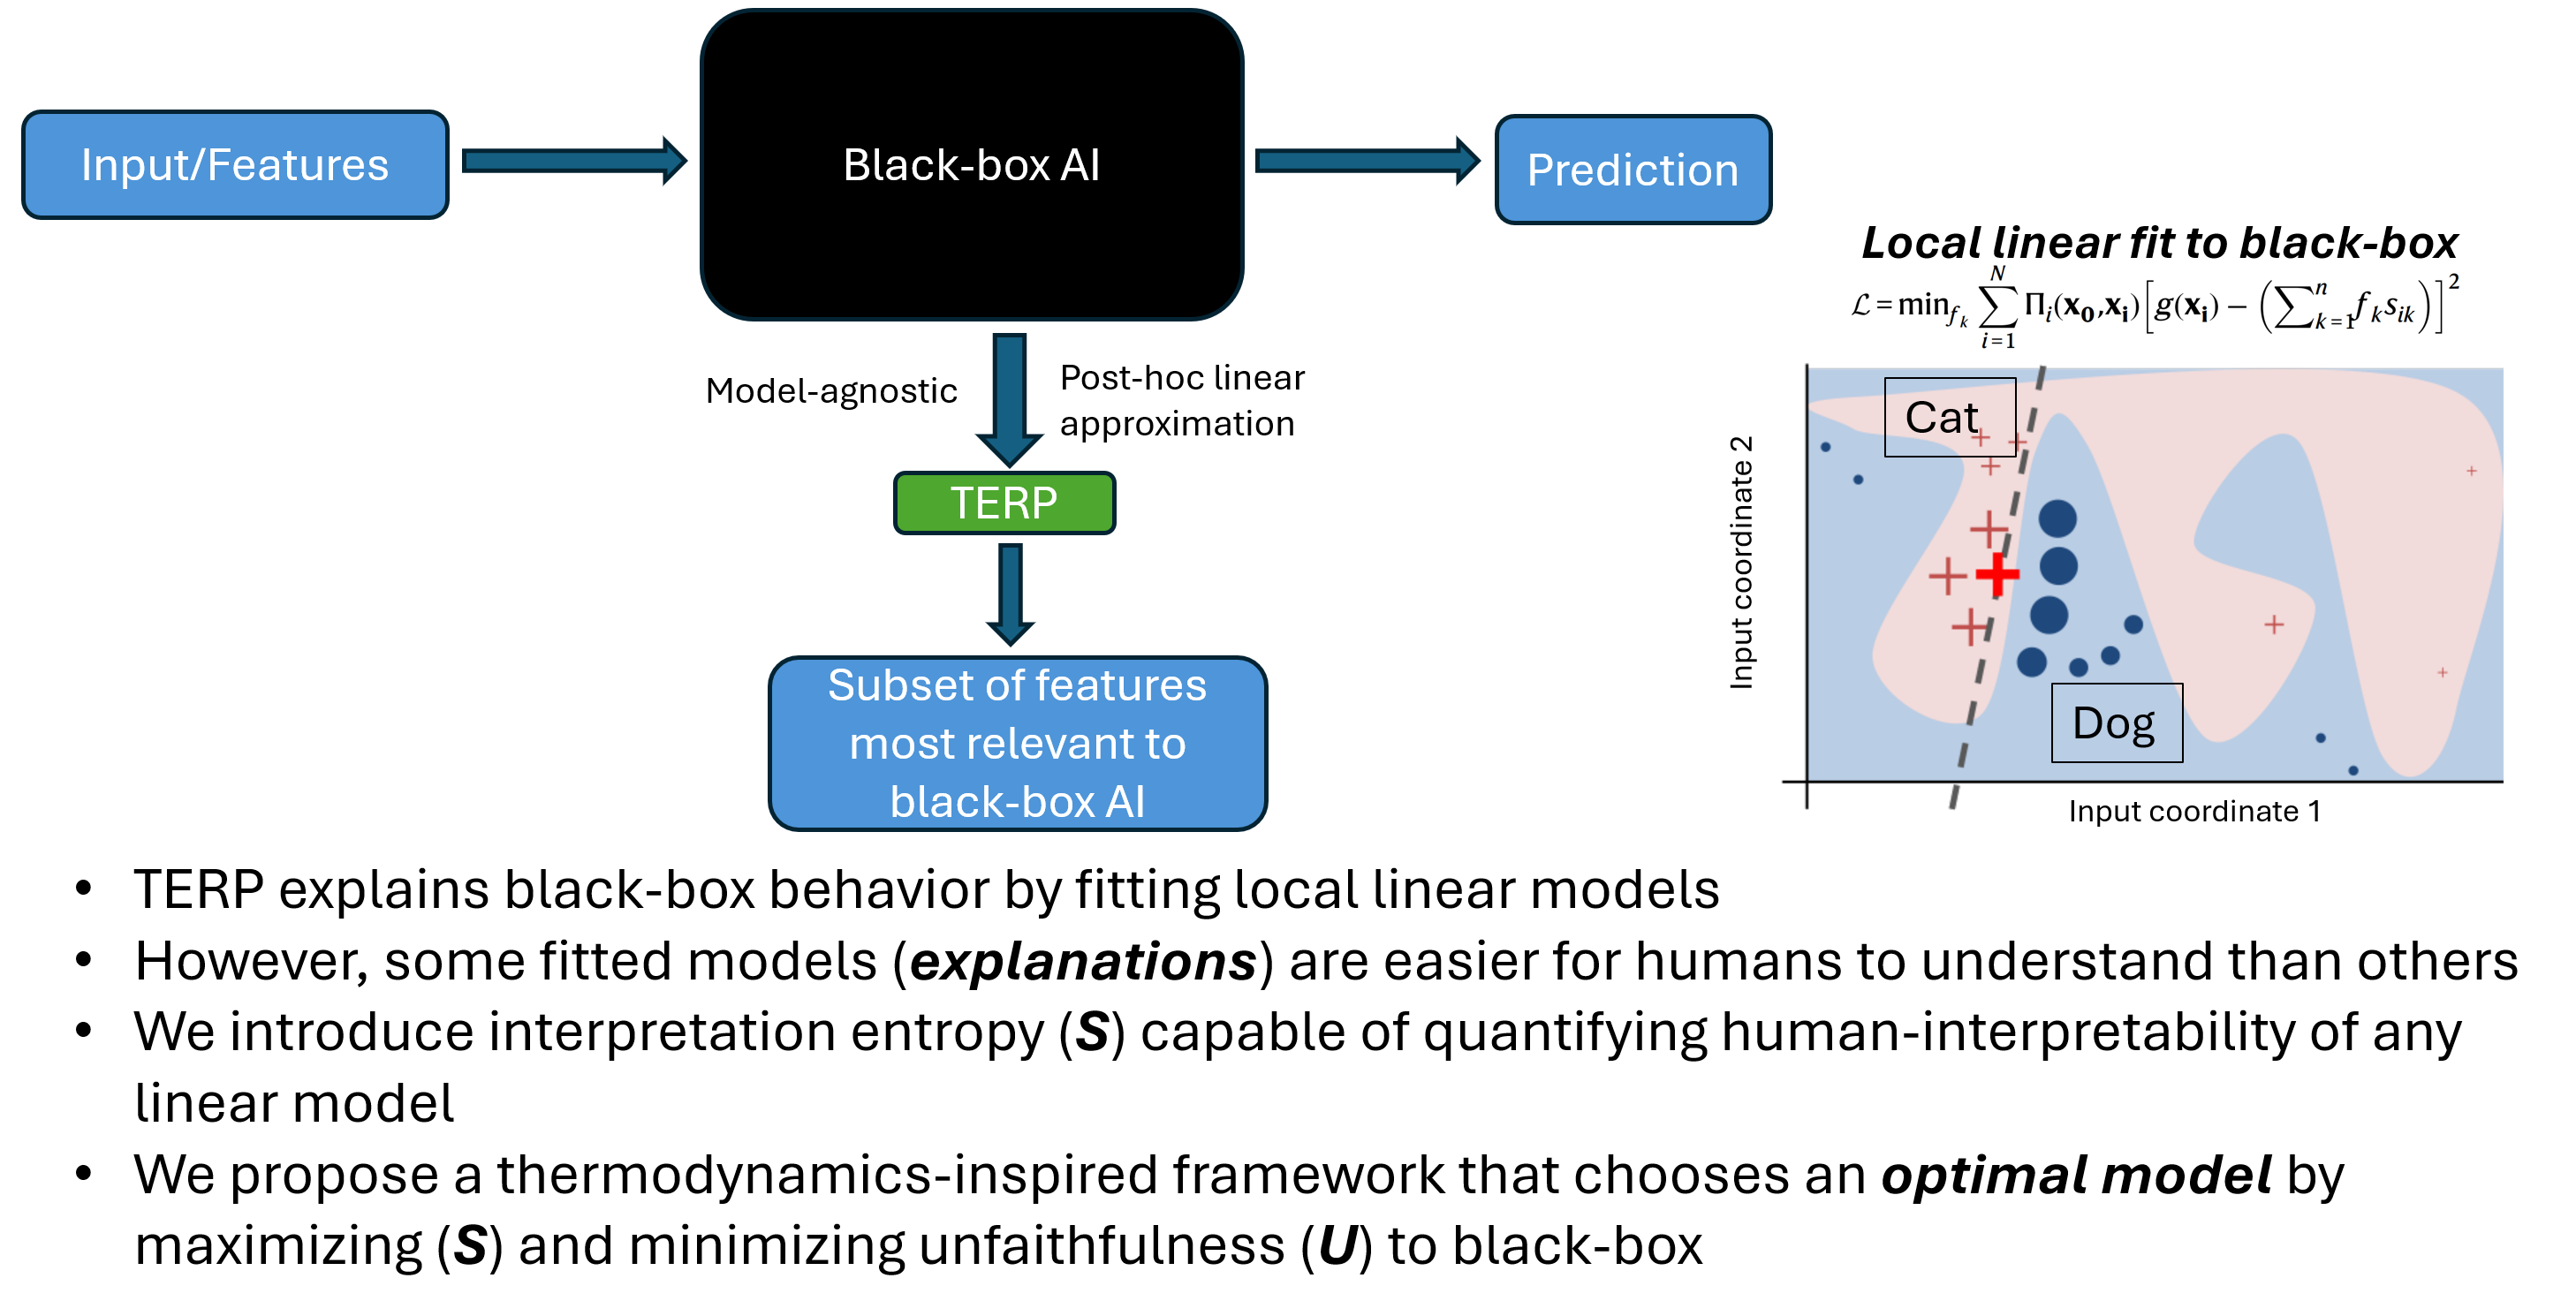

## **Installations and loading libraries ...**

In [1]:
!pip install deeptime --verbose

from IPython.display import Image
import matplotlib.pyplot as plt
import scipy.stats as sst
import numpy as np
import torch

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Obtaining dependency information for deeptime from https://files.pythonhosted.org/packages/ab/b5/00076a0f905327aff3c7f24d586cdbf0789530166774950eef056edc1a2e/deeptime-0.4.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.7 MB/s eta 0:00:00


In [2]:
!npx degit -f tiwarylab/TERP
!npx degit -f shams-mehdi/TERP_tutorial

Need to install the following packages:
  degit@2.8.4
Ok to proceed? (y) y
> destination directory is not empty. Using --force, continuing
> cloned tiwarylab/TERP#HEAD
> destination directory is not empty. Using --force, continuing
> cloned shams-mehdi/TERP_tutorial#HEAD


**Application 1.** Core scripts with synthetic data (tabular) + linear model   

*   We will build a linear model that takes 10 features as inputs, 3/10 are relevant for prediction with coefficients 3,5,-2 respectively. Using TERP we will validate this feature importance attribution

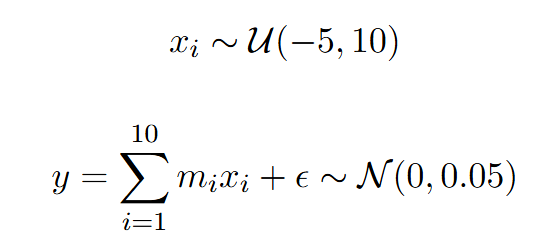

In [3]:
# @title Generate input data + define model, Input feature coefficients
C0 = 3 # @param {"type":"integer"}
C1 = 0 # @param {"type":"integer"}
C2 = 0 # @param {"type":"integer"}
C3 = 5 # @param {"type":"integer"}
C4 = 0 # @param {"type":"integer"}
C5 = 0 # @param {"type":"integer"}
C6 = -2 # @param {"type":"integer"}
C7 = 0 # @param {"type":"integer"}
C8 = 0 # @param {"type":"integer"}
C9 = 0 # @param {"type":"integer"}
dataset_size = 1000 # @param {"type":"integer"}
######################################
# Generate input data
######################################
np.random.seed(0)

coefficients_array = np.array([C0,C1,C2,C3,C4,C5,C6,C7,C8,C9])
input = np.random.uniform(-5,10, size = (dataset_size, coefficients_array.shape[0]))

input_fname = 'input_data.npy'
np.save(input_fname, input)
print('Input data generated -> '+ input_fname)
######################################
# Define prediction function/model
######################################

def prediction(inp_data, coef_array):
  eps = np.random.normal(0,0.05)
  prediction = np.sum(inp_data*coef_array, axis = -1) + eps
  return prediction

output = prediction(input, coefficients_array)
output_fname = 'output_data.npy'
np.save(output_fname, output)
print('Output data generated -> '+ output_fname)

Input data generated -> input_data.npy
Output data generated -> output_data.npy


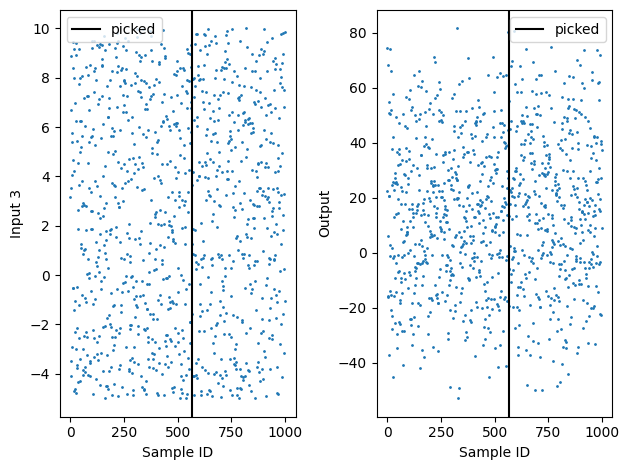

In [4]:
# @title Visualize input, output. Choose a sample for explanation (not relevant for linear models)
Feature_index = 3 # @param {"type":"integer"}
picked_index = 567 # @param {"type":"integer"}


fig, ax = plt.subplots(1, 2)
ax[0].plot(input[:, Feature_index], 'o',markersize = 1)
ax[1].plot(output, 'o', markersize = 1)
ax[0].axvline(picked_index, color = 'k', label = 'picked')
ax[1].axvline(picked_index, color = 'k', label = 'picked')

ax[0].set_ylabel('Input ' + str(Feature_index))
ax[1].set_ylabel('Output')
ax[0].set_xlabel('Sample ID')
ax[1].set_xlabel('Sample ID')
ax[0].legend()
ax[1].legend()
fig.tight_layout()

**TERP step 1**: Neighborhood data generation (5000 perturbed samples) around picked index (no -index flag selects first entry in the input by default)  
**Helper script 1: TERP_neighborhood_generator.py** (supports specific perturbations for numeric, categorical, periodic, sin/cos, images, no text)  
**Flags**:  


*   -seed -> Random seed (0)
*   -input_numeric -> For numeric data type
*   -num_samples -> Sample size in neighborhood (10000)
*   -index -> Prediction to explain (0)
*   --progress_bar -> Shows progress using tqdm

**Creates**  
 2 files in **DATA** directory. One for making prediction (**make_prediction_numeric.npy**), one for running TERP (**TERP_numeric.npy**)





In [5]:
!python TERP_neighborhood_generator.py -seed 0  -input_numeric input_data.npy -num_samples 10000 -index 0 --progress_bar

>>> Numerical data provided...
>>> Generating data...
100% 10000/10000 [00:00<00:00, 74620.06it/s]
>>> Data generation complete!
Files saved in :::  /content/DATA


**TERP step 2:** Obtain predictions using the model defined before for the generated samples (will need to be adapted for your model -> **breakpoints** make the implementation challenging)  

**Creates**  
Numpy array DATA/neighborhood_state_probabilities.npy

In [6]:
pred_1 = prediction(np.load('DATA/make_prediction_numeric.npy'), coefficients_array)
np.save('DATA/neighborhood_state_probabilities.npy', pred_1)
print(np.load('DATA/TERP_numeric.npy').shape, pred_1.shape)

(10000, 10) (10000,)


**TERP step 3:** Run **helper script 2: TERP_optimizer_01.py**  

*   Does initial round of linear regression (useful for discarding irrelevant features when high number of input features are present in the dataset)
*   **DOES NOT IMPLEMENT** forward feature selection. Not capable of finding optimal model

**Flags**:  


*   -explain_class -> relevant for multi-class models (e.g, SPIB) i.e, when output has multiple columns. Not relevant here (regressor)
*   -cutoff -> Keeps top **N** features (e.g., relevant for images). Defaults to **25**
*   --euclidean -> Metric for computing similarity (optional, possible choice for numeric data)
*   --cosine_d -> Metric for computing similarity (optional, possible choice for images/text)
*   No similarity flag default to LDA
*   Creates several files in **TERP_results** directory
*  Note the presence of indices **3, 0, 6**. However other indices are present as well. TERP is used to find the optimal model i.e., gets rid of the non-contributing ones in subsequent steps

**Creates**  
**TERP_results/selected_features.npy**



In [7]:
!python TERP_optimizer_01.py -TERP_input DATA/TERP_numeric.npy -blackbox_prediction DATA/neighborhood_state_probabilities.npy

----------------------------------------------------------------------------------------------------
11-01-24 18:09:49 initialization  INFO     Starting TERP...
----------------------------------------------------------------------------------------------------
11-01-24 18:09:49 initialization  INFO     Input data read successful ...
11-01-24 18:09:49 initialization  WARNING  explain_class not provided, defaulting to class with maximum predictiion probability :: 0
11-01-24 18:09:49 initialization  WARNING  Cutoff not provided. Defaulting to :: 25
11-01-24 18:09:49 initialization  INFO     No distance flag provided. Performing 1-d LDA projection to compute similarity measure!
11-01-24 18:09:49 initialization  WARNING  Top 25 features selected with weight coverage :: 1.0!!
11-01-24 18:09:49 initialization  INFO     Selected the following 10 out of (10) features to form a feature sub-space ::
11-01-24 18:09:49 initialization  INFO     [3, 0, 6, 5, 2, 8, 9, 7, 4, 1]


**TERP step 4:** Generate a new neighborhood using the same helper script **TERP_neighborhood_generator.py** with **only** the selected features (**also helps with random sampling of a reduced space**)  :



*   Same **Flags** as **TERP step 1** with an additional **-selected_features** TERP_results/selected_features.npy:  
*   Note: With *a priori* information, you can create your own array of possibly relevant features and pass as an array
*   Technically can directly start from this step and still will be fast, if number of features are not too high (e.g., less than 25)


**Creates**
2 files in **DATA_2** directory just as step 1

In [8]:
!python TERP_neighborhood_generator.py -seed 0 --progress_bar -input_numeric input_data.npy -num_samples 10000 -index 0 -selected_features TERP_results/selected_features.npy

>>> Numerical data provided...
>>> Generating data...
100% 10000/10000 [00:00<00:00, 77712.30it/s]
>>> Data generation complete!
Files saved in :::  /content/DATA_2


**TERP step 5:** Obtain predictions using the model defined just as before  
**Creates**  
Numpy array DATA_2/neighborhood_state_probabilities.npy

In [9]:
pred_2 = prediction(np.load('DATA_2/make_prediction_numeric.npy'), coefficients_array)
np.save('DATA_2/neighborhood_state_probabilities.npy', pred_2)
print(np.load('DATA_2/TERP_numeric.npy').shape, pred_2.shape)

(10000, 10) (10000,)


**TERP (final) step 6:** Run **main script: TERP_optimizer_02.py**  

*   Implements forward feature selection to generate a family of candidate models
*   Calculates U(j), S(j), θ(j) for all the models
*   Generates the most stable model with widest range in θ
*   Technically you can do Ridge regression (L2 norm) while fitting linear models using very small α for robustness, S(j) quantification can sit on top (selected by default. Can be turned off)

**Flags**:  


*   -explain_class -> relevant for multi-class models (e.g, SPIB) i.e, when output has multiple columns. Not relevant here (regressor)
*   --euclidean -> Metric for computing similarity (optional, possible choice for numeric data)
*   --cosine_d -> Metric for computing similarity (optional, possible choice for images/text)
*   No similarity flag default to LDA
*   Flags are mostly same as before with some extra ones (optional)
*   Creates several files in **TERP_results_2** directory




In [10]:
!python TERP_optimizer_02.py -TERP_input DATA_2/TERP_numeric.npy -blackbox_prediction DATA_2/neighborhood_state_probabilities.npy -selected_features TERP_results/selected_features.npy

----------------------------------------------------------------------------------------------------
11-01-24 18:09:58 initialization  INFO     Starting TERP...
----------------------------------------------------------------------------------------------------
11-01-24 18:09:58 initialization  INFO     Input data read successful ...
11-01-24 18:09:58 initialization  WARNING  explain_class not provided, defaulting to class with maximum predictiion probability :: 0
11-01-24 18:09:58 initialization  INFO     No distance flag provided. Performing 1-d LDA projection to compute similarity measure!
11-01-24 18:09:58 initialization  INFO     Feature selection results read successful!
11-01-24 18:09:58 initialization  INFO     Similarity computation complete...
----------------------------------------------------------------------------------------------------
Number of models constructed:: 100% 10/10 [00:02<00:00,  4.63it/s]
11-01-24 18:10:00 TERP_SGD_step_02 INFO     Analysis complete! Compu

**Analysis**

**Questions**  
*  Whats forward feature selection?
*  After fitting, how U, S, θ are calculated?
*  How the optimal model is chosen?
*  How to interpret TERP results?

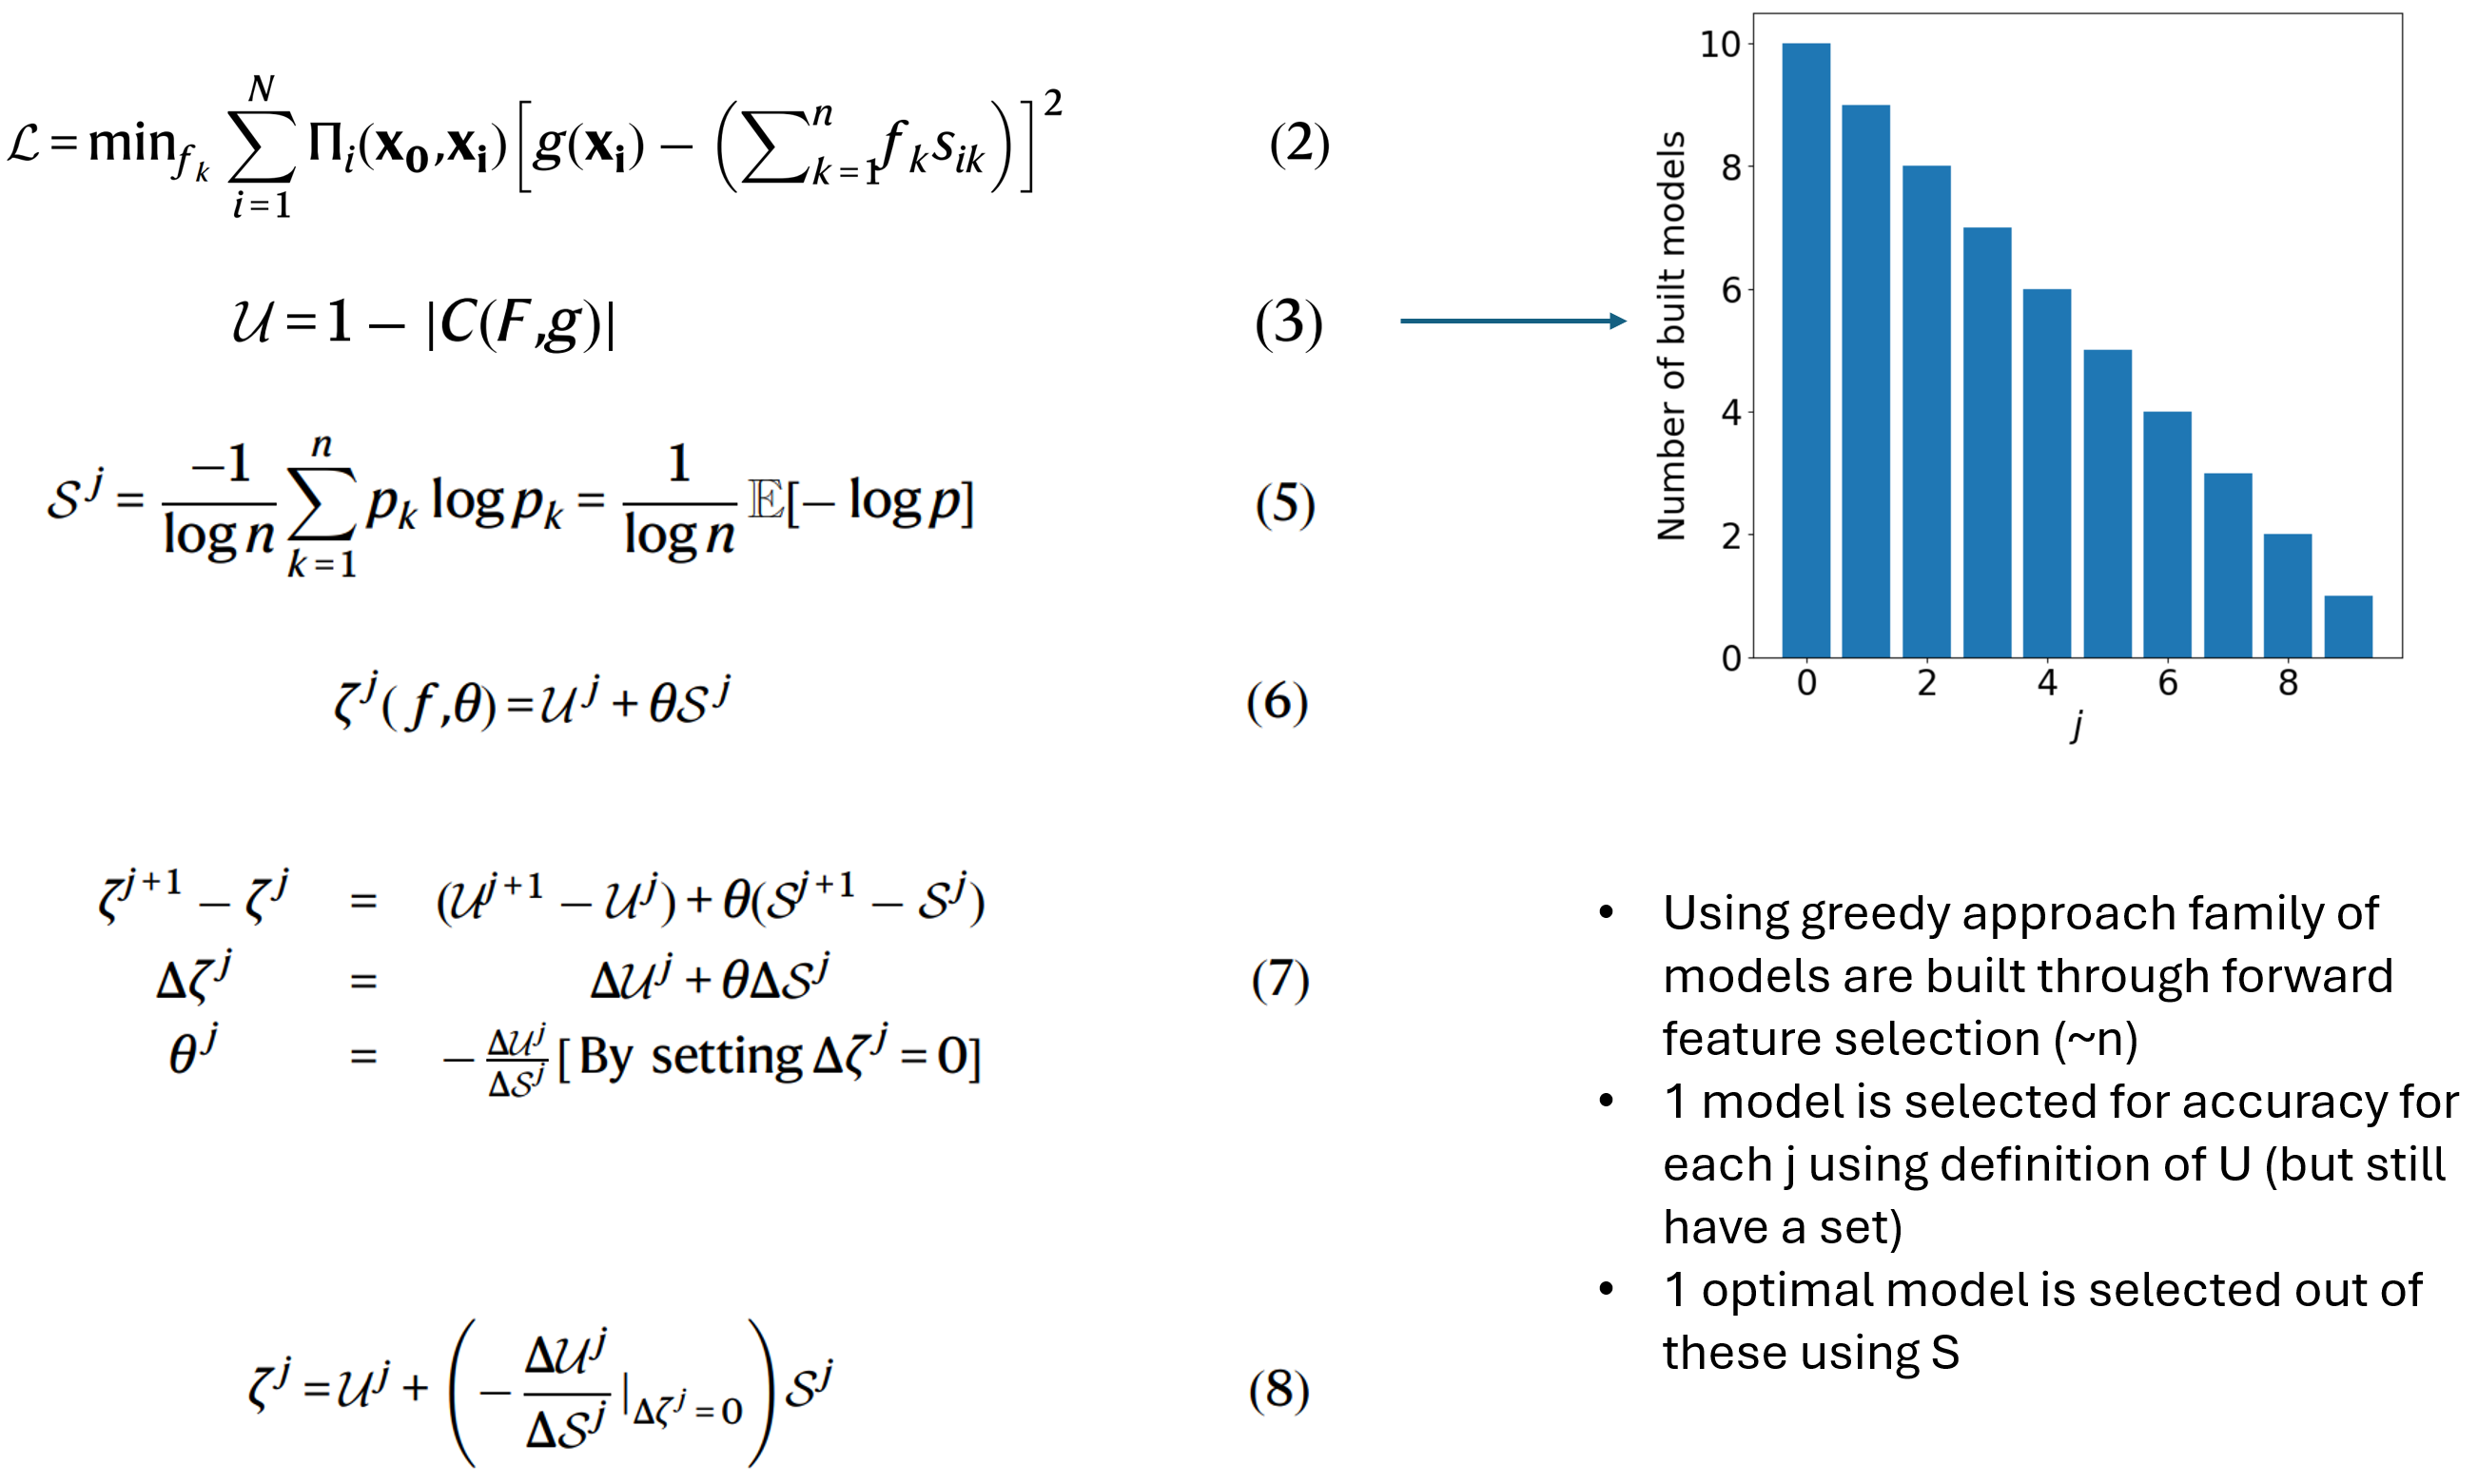

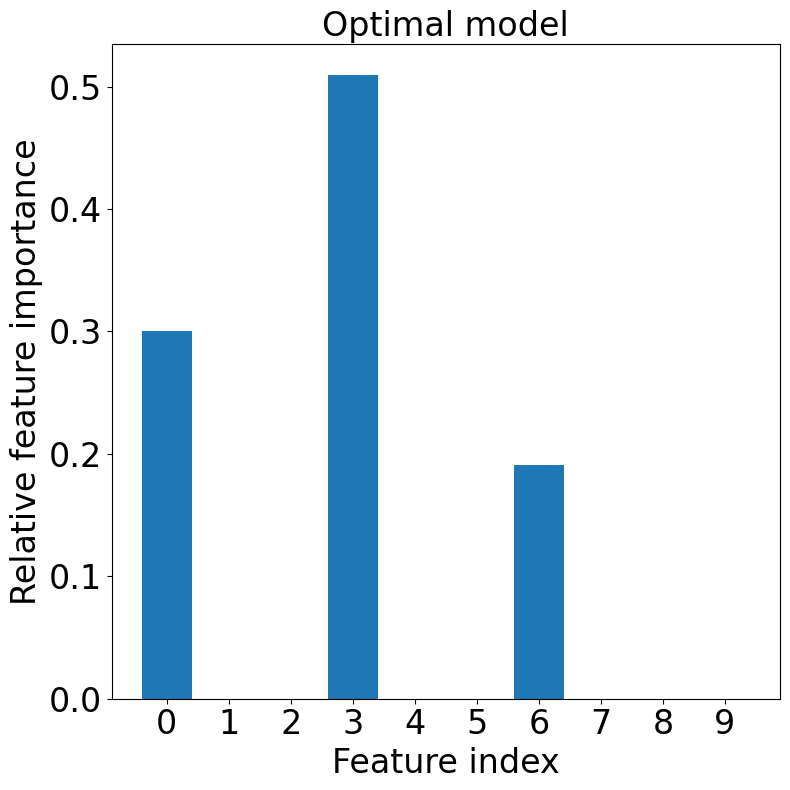

In [11]:
# @title Load TERP_results_2/optimal_feature_weights.npy and plot weights for the optimally chosen model
######################################
# Analysis
######################################
w = np.load('TERP_results_2/optimal_feature_weights.npy')
fig, ax = plt.subplots(figsize = (8,8))
ax.bar(np.arange(w.shape[0]), w)
ax.set_xticks(np.arange(w.shape[0]))
ax.set_xlabel(r'Feature index', fontsize = 24)
ax.set_ylabel('Relative feature importance', fontsize = 24)
ax.set_title('Optimal model', fontsize = 24)

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=8)
fig.tight_layout()

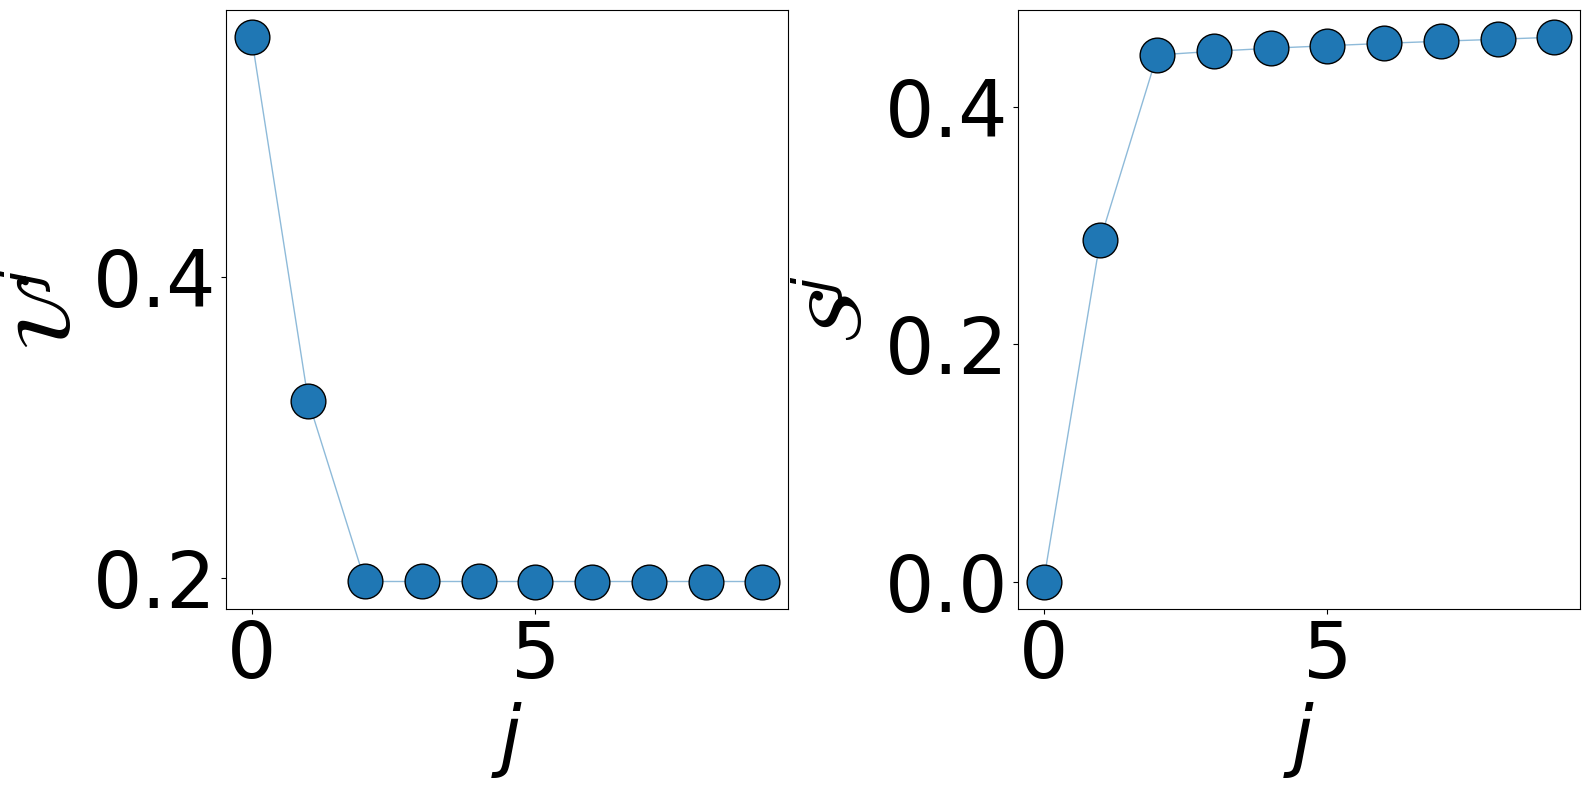

In [12]:
# @title Load TERP_results_2/unfaithfulness_scores_final.npy and TERP_results_2/interpretation_entropy_final.npy for plotting U(j), S(j)
U = np.load('TERP_results_2/unfaithfulness_scores_final.npy')
S = np.load('TERP_results_2/interpretation_entropy_final.npy')

fig, ax = plt.subplots(1, 2, figsize = (16, 8))

u_ultra = U
s_ultra = S

ax[0].plot(U, color = 'tab:blue', lw = 1, alpha = 0.5)
ax[0].plot(U,'o', markersize = 25, markeredgecolor = 'k', label = r'$\mathcal{U}_k$')
ax[0].set_ylabel(r'$\mathcal{U}^j$', fontsize = 56)
ax[0].set_xlabel(r'$j$', fontsize = 56)

ax[0].tick_params(axis='both', which='major', labelsize=56)
ax[0].tick_params(axis='both', which='minor', labelsize=8)

ax[1].plot(S, color = 'tab:blue', lw = 1, alpha = 0.5)
ax[1].plot(S,'o', markersize = 25, markeredgecolor = 'k', label = r'$\mathcal{S}_k$')
ax[1].set_ylabel(r'$\mathcal{S}^j$', fontsize = 56)
ax[1].set_xlabel(r'$j$', fontsize = 56)

ax[1].tick_params(axis='both', which='major', labelsize=56)
ax[1].tick_params(axis='both', which='minor', labelsize=8)
fig.tight_layout()

Sanity check :  3


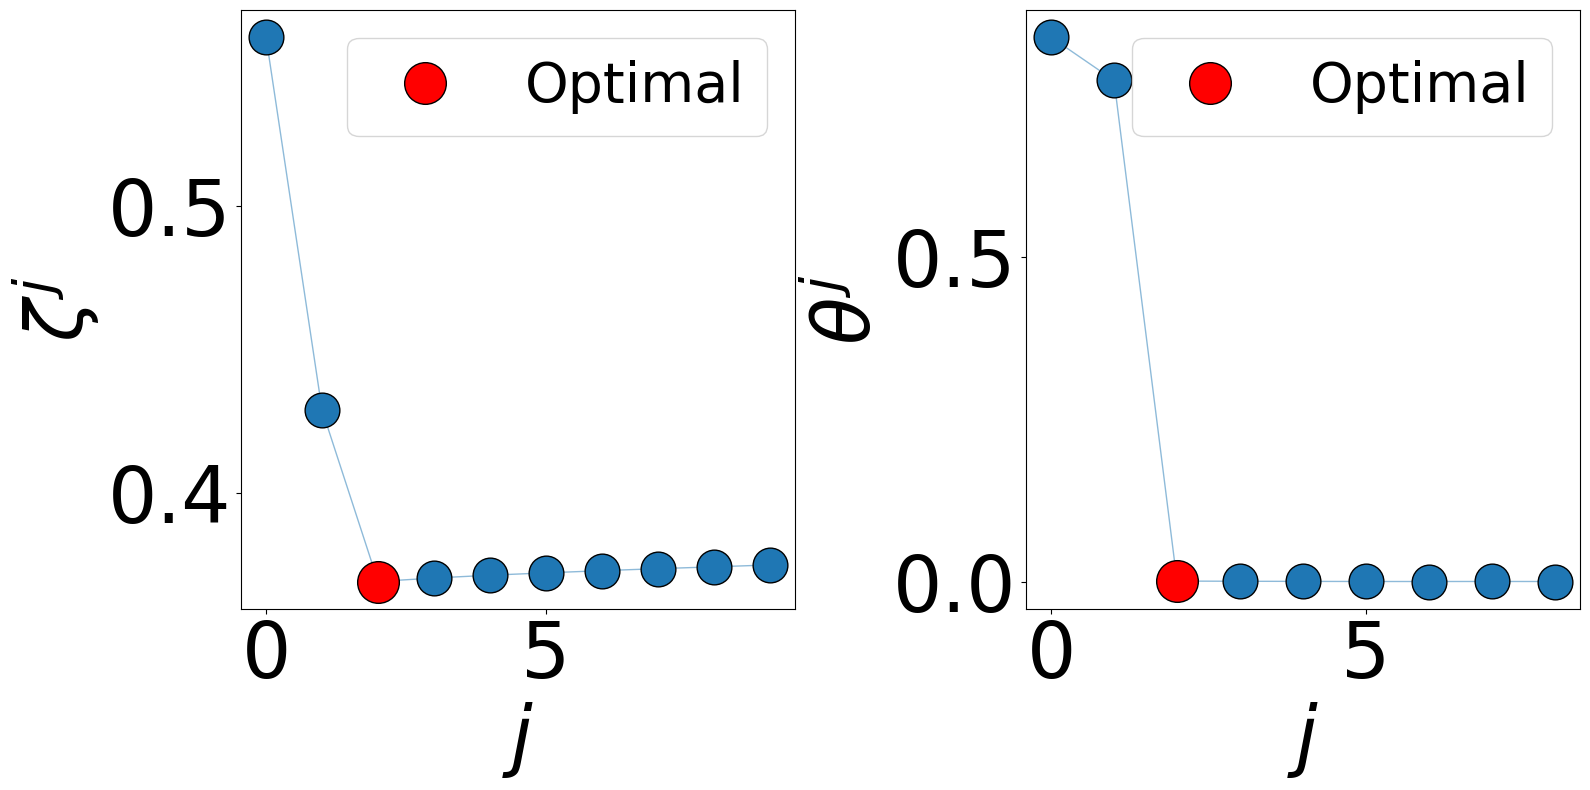

In [13]:
# @title Load TERP_results_2/charac_theta.npy and TERP_results_2/range_theta.npy for plotting ζ(j), θ(j)
T = np.load('TERP_results_2/charac_theta.npy')
T_range = np.load('TERP_results_2/range_theta.npy')

stable_model = np.argmin(T_range) + 2 # +2 takes care of indices
stable_T = (T[stable_model - 1] + T[stable_model - 2])/2


#print('Most stable model at k :: ', stable_model, ' at temperature :: ', "{:10.2f}".format(stable_T))

fig, ax = plt.subplots(1, 2, figsize = (16,8))

ax[0].plot(stable_T*S+U, color = 'tab:blue', lw = 1, alpha = 0.5)
ax[0].plot(stable_T*S+U,'o', markersize = 25, markeredgecolor = 'k')
ax[0].plot(stable_model-1, (stable_T*S+U)[stable_model-1], 'o',color = 'red', markersize = 30, markeredgecolor = 'k', label = 'Optimal')
z_ultra = stable_T*S+U

#ax.set_ylim(0,1)
ax[0].set_ylabel(r'$\zeta^j$', fontsize = 56)
ax[0].set_xlabel(r'$j$', fontsize = 56)
ax[0].tick_params(axis='both', which='major', labelsize=56)
ax[0].tick_params(axis='both', which='minor', labelsize=8)
ax[0].legend(fontsize = 40)


ax[1].plot(T, color = 'tab:blue', lw = 1, alpha = 0.5)
ax[1].plot(T,'o', markersize = 25, markeredgecolor = 'k')
t_ultra = T
print('Sanity check : ', np.argmin(stable_T*S+U)+1)
ax[1].set_ylabel(r'$\theta^j$', fontsize = 56)

ax[1].plot(stable_model-1, T[stable_model-1], 'o',color = 'red', markersize = 30, markeredgecolor = 'k', label = 'Optimal')
ax[1].set_xlabel(r'$j$', fontsize = 56)
ax[1].tick_params(axis='both', which='major', labelsize=56)
ax[1].tick_params(axis='both', which='minor', labelsize=8)
ax[1].legend(fontsize = 40)
fig.tight_layout()

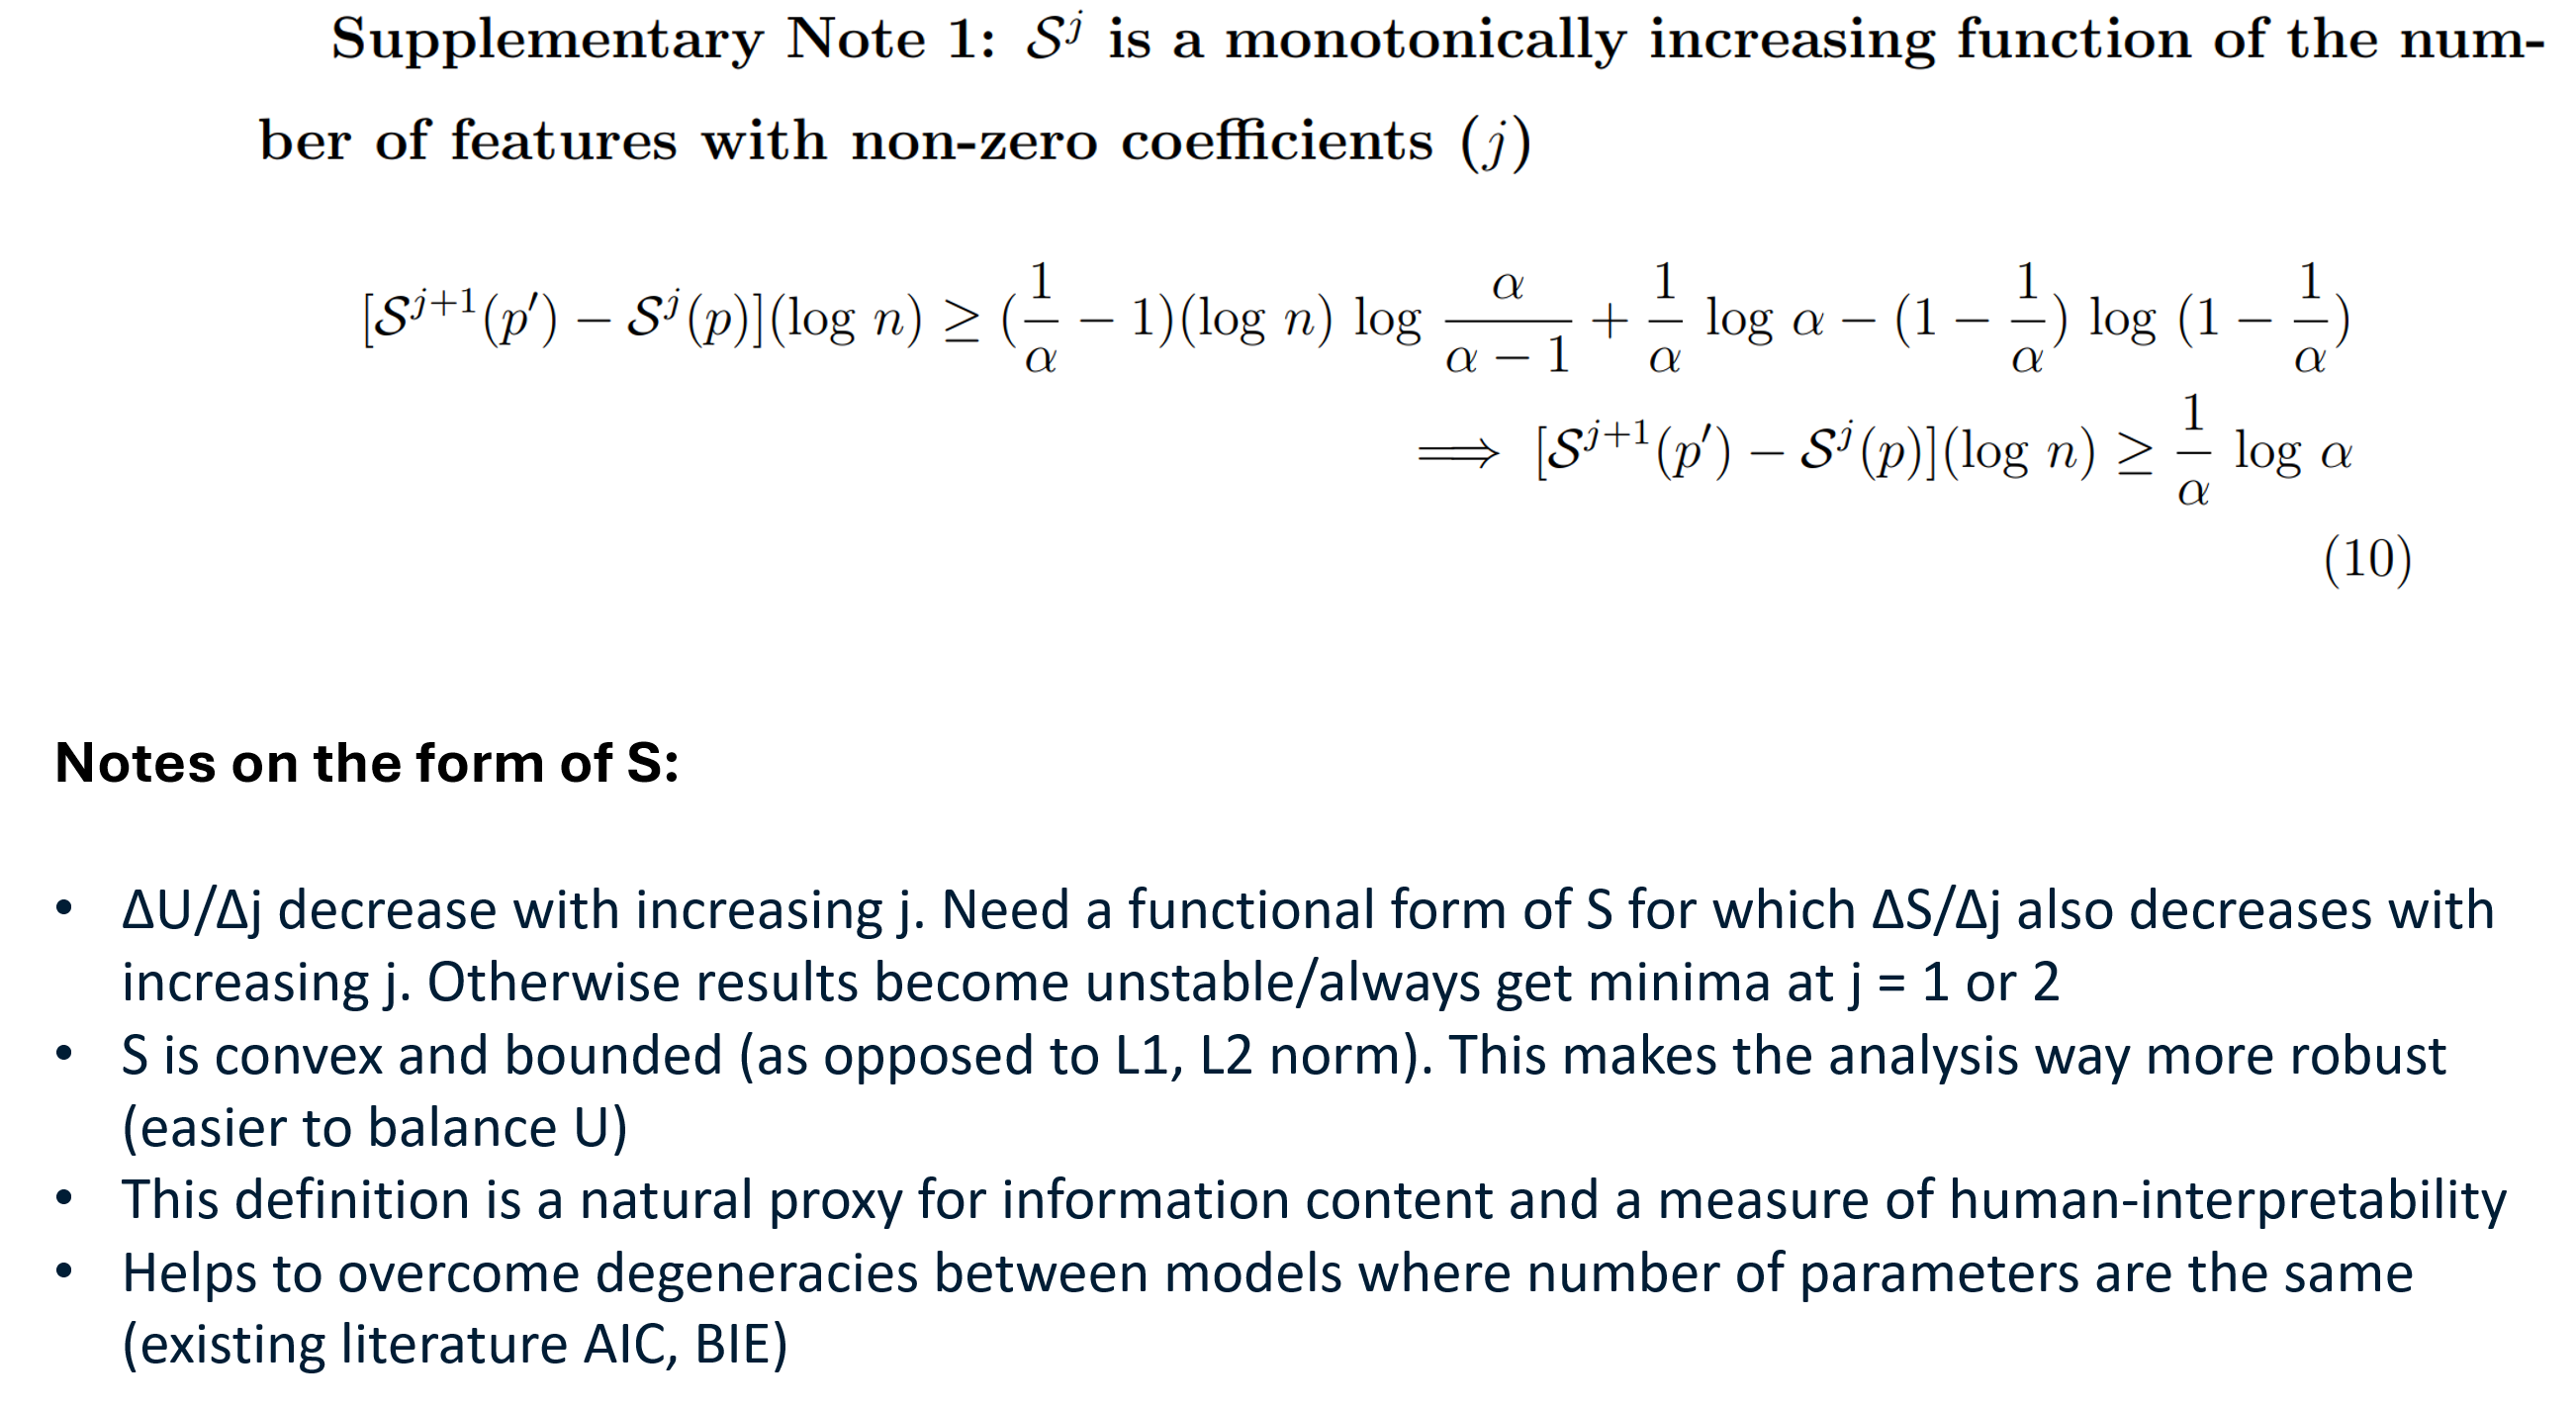



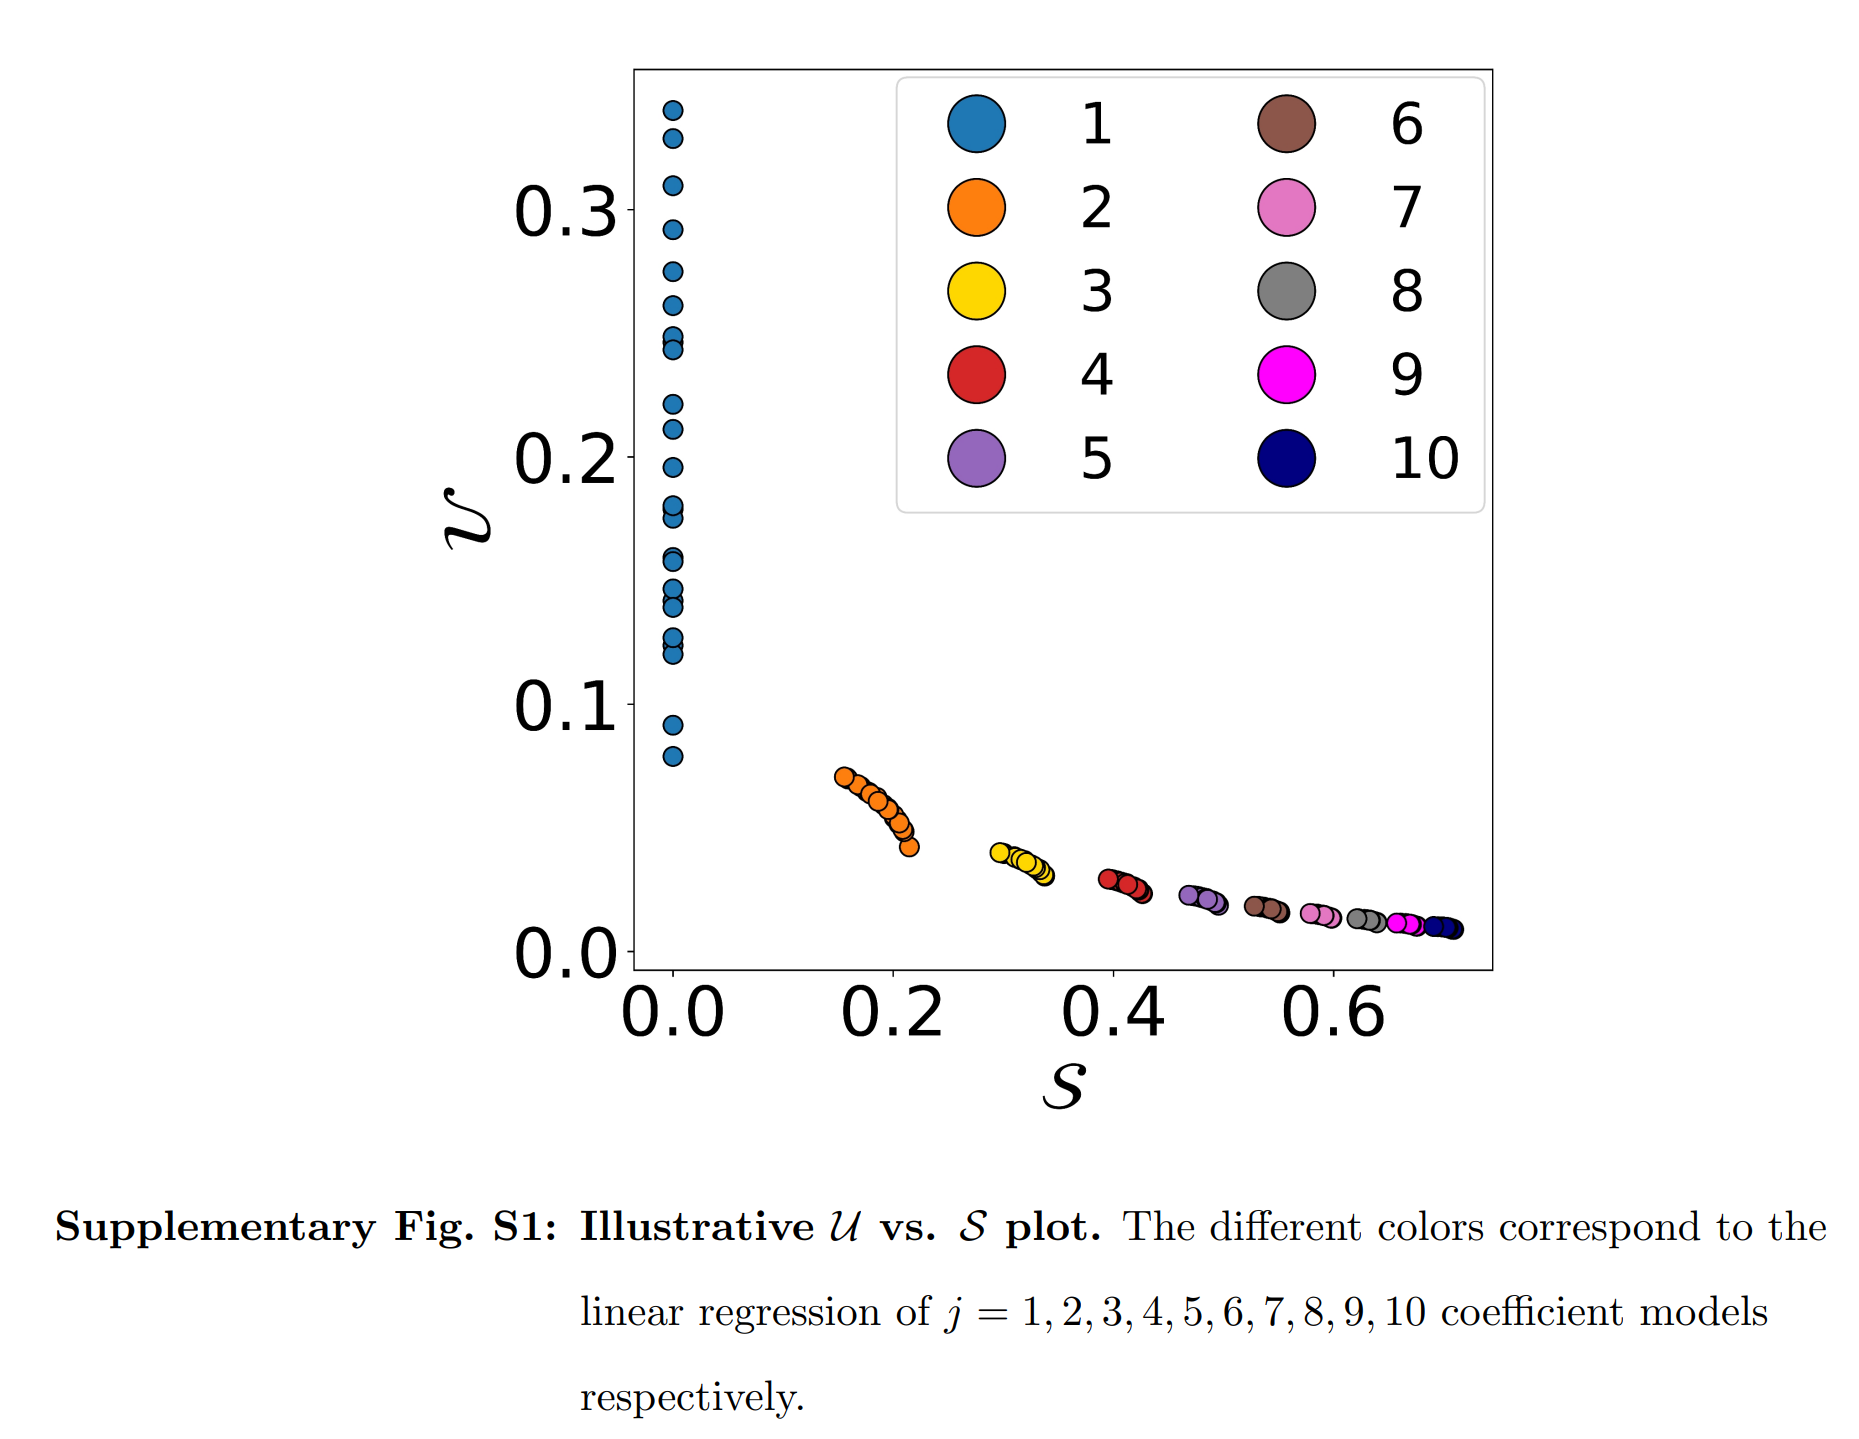

**Application 2.** MD data  (periodic) + VAMPnets

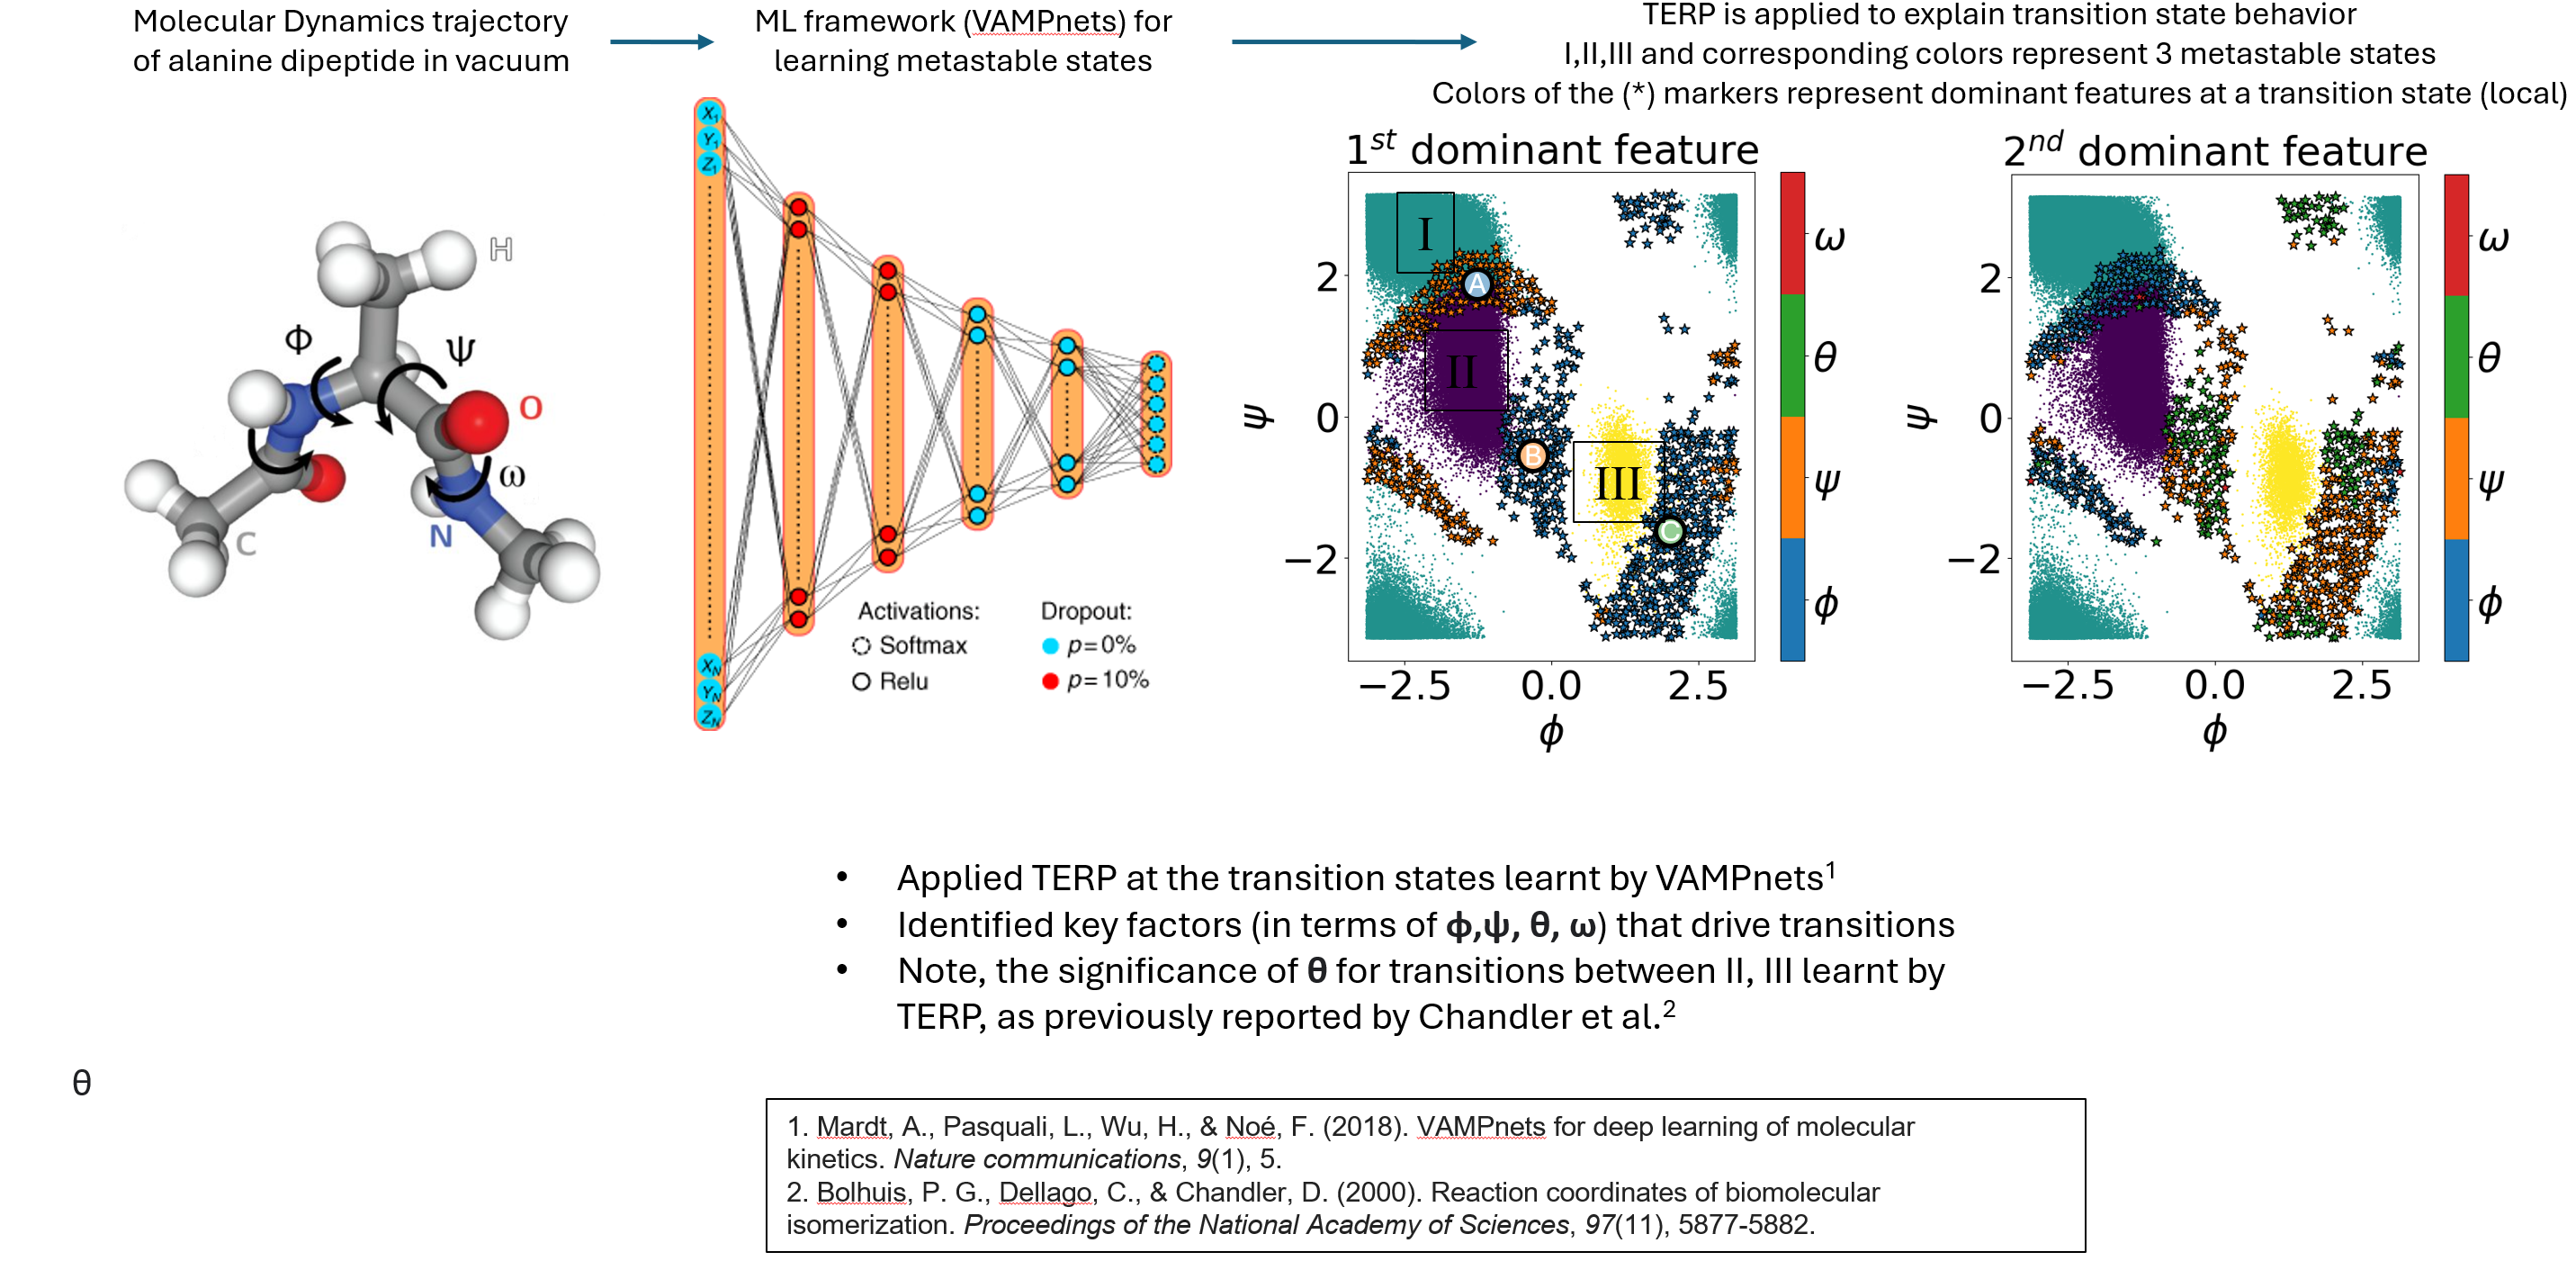

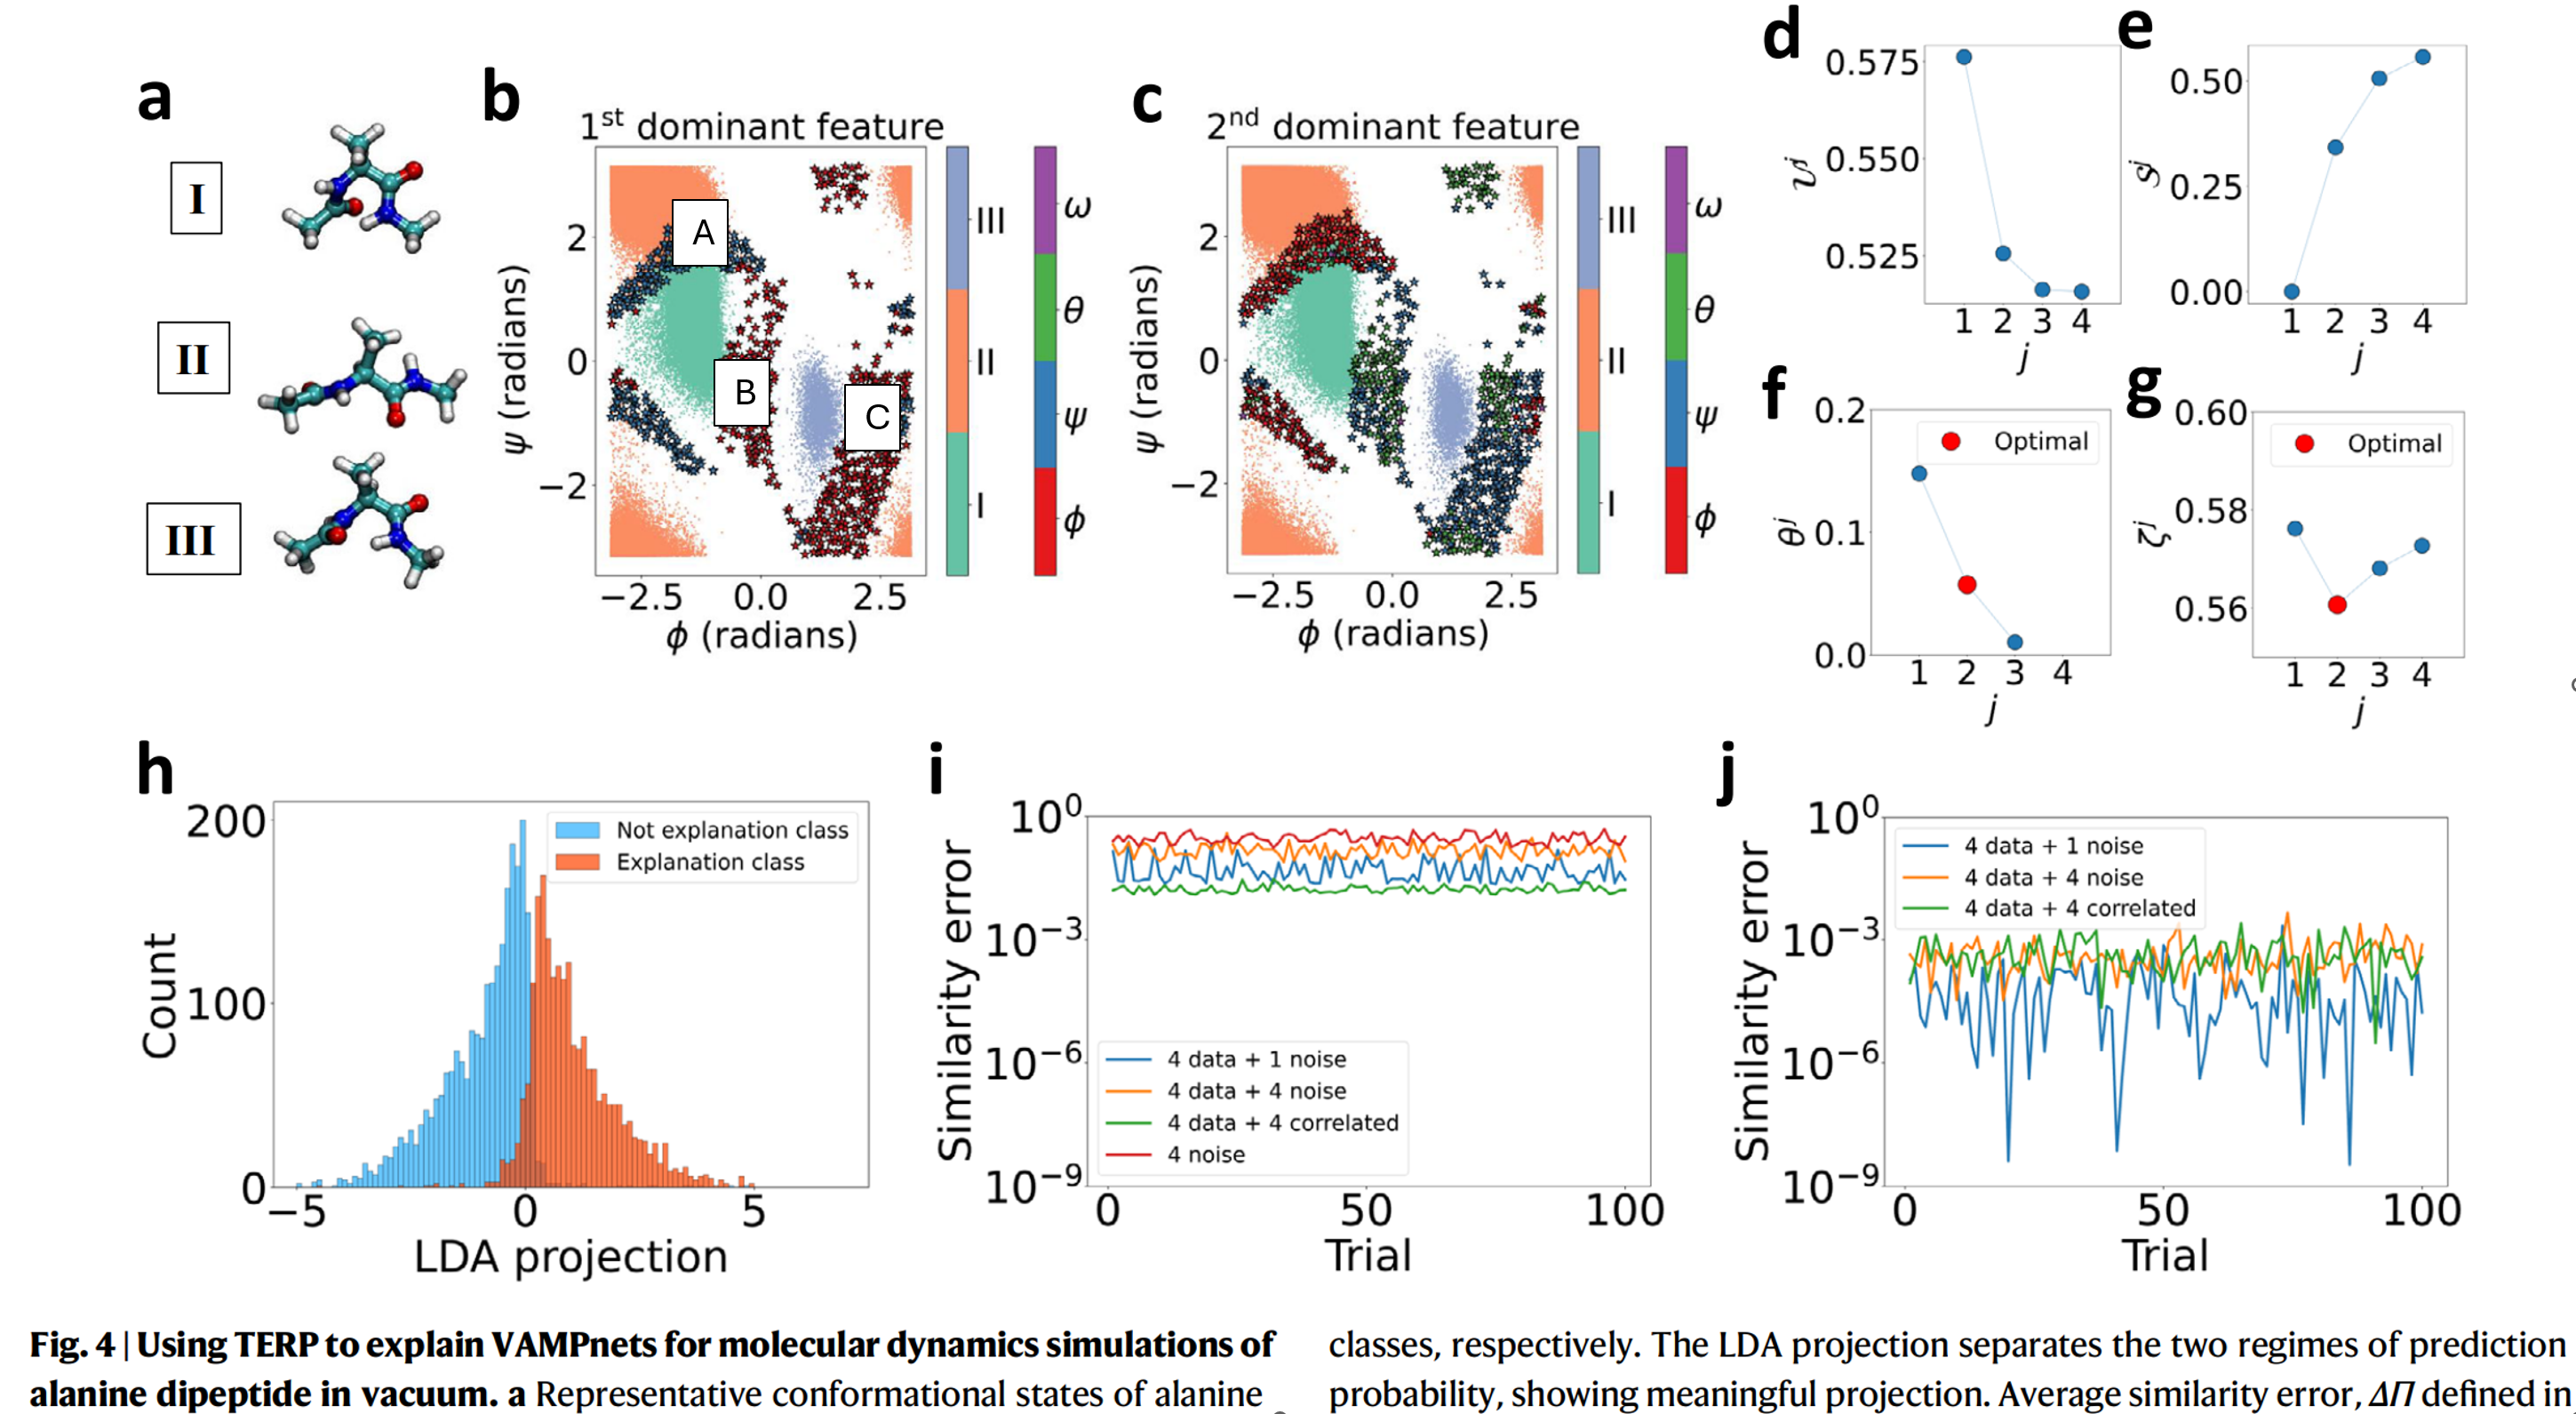

In [14]:
#@title LOAD aladip data and save sin-cos separated data
aladip_data = np.load('aladip_unbiased_trajectory.npy')[::10,:] # reduced resolution compared to paper for efficiency
traj = np.zeros((aladip_data.shape[0], 8))
for i in range(4):
  traj[:, 2*i] = np.sin(aladip_data[:,i])
  traj[:, 2*i+1] = np.cos(aladip_data[:,i])

np.save('sin.npy', traj[:,::2])
np.save('cos.npy',traj[:,1::2])

print("Alanine dipeptide MD data loaded. Array shape:: ", aladip_data.shape)
print("Sin-cos separated data saved for TERP!")

Alanine dipeptide MD data loaded. Array shape::  (200000, 4)
Sin-cos separated data saved for TERP!


<ipython-input-19-6a316802a581>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model')


State 1 minimum and maximum probabilities in the dataset: [0.003248553955927491, 0.6495415568351746]
State 2 minimum and maximum probabilities in the dataset: [0.0063583035953342915, 0.8336654901504517]
State 3 minimum and maximum probabilities in the dataset: [0.0545002706348896, 0.9903931021690369]


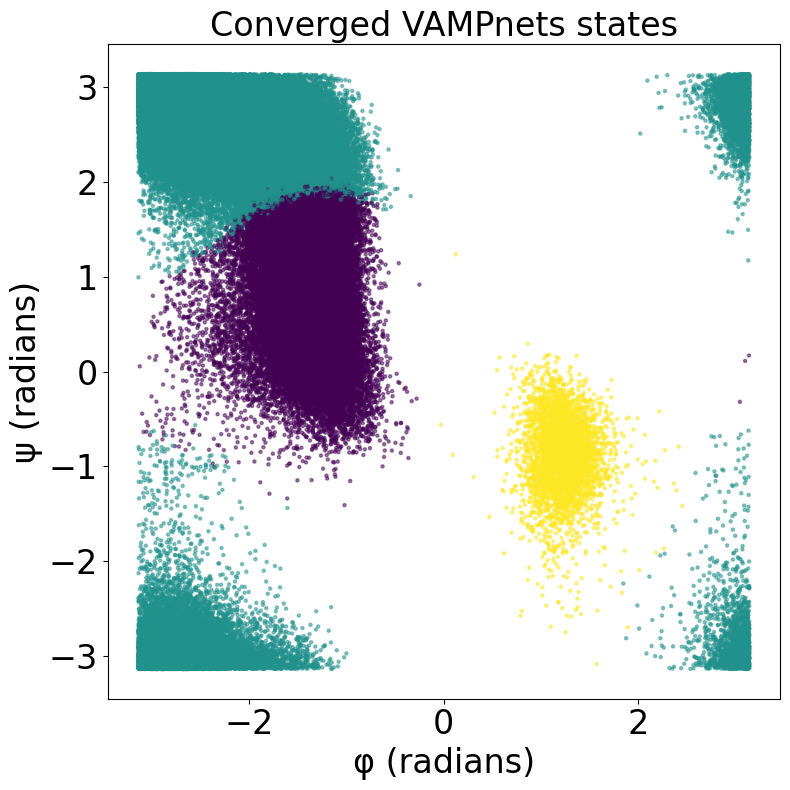

In [19]:
#@title LOAD trained VAMPnets model and pass dihedral angle data for determining metastable states
model = torch.load('model')
state_probabilities = model.transform(traj)

for ix, (mini, maxi) in enumerate(zip(np.min(state_probabilities, axis=0),
                                      np.max(state_probabilities, axis=0))):
    print(f"State {ix+1} minimum and maximum probabilities in the dataset: [{mini}, {maxi}]")

assignments = state_probabilities.argmax(1)

fig, ax = plt.subplots(figsize = (8,8))
state_probabilities = model.transform(traj)
assignments = state_probabilities.argmax(1)
ax.scatter(aladip_data[:, 0], aladip_data[:, 1], c=assignments[:], s=5, alpha=0.5)
ax.set_title('Converged VAMPnets states', fontsize = 24)
ax.set_xlabel('φ (radians)', fontsize = 24)
ax.set_ylabel('ψ (radians)', fontsize = 24)
ax.tick_params(axis='x', labelsize= 24)
ax.tick_params(axis='y', labelsize= 24)
fig.tight_layout()

Pick a point to explain predictions. Points A, B, C are from paper. Can TERP be applied for **basins** instead of **transition** states (as long as there is a probability gradient, yes!)? Try out **Custom**.

Increasing threshold :0.4
Searching points near::  [0, 0, 0, 2.941592653589793]
Found::  [-0.391641, -0.170901, -0.056052, 2.970761]


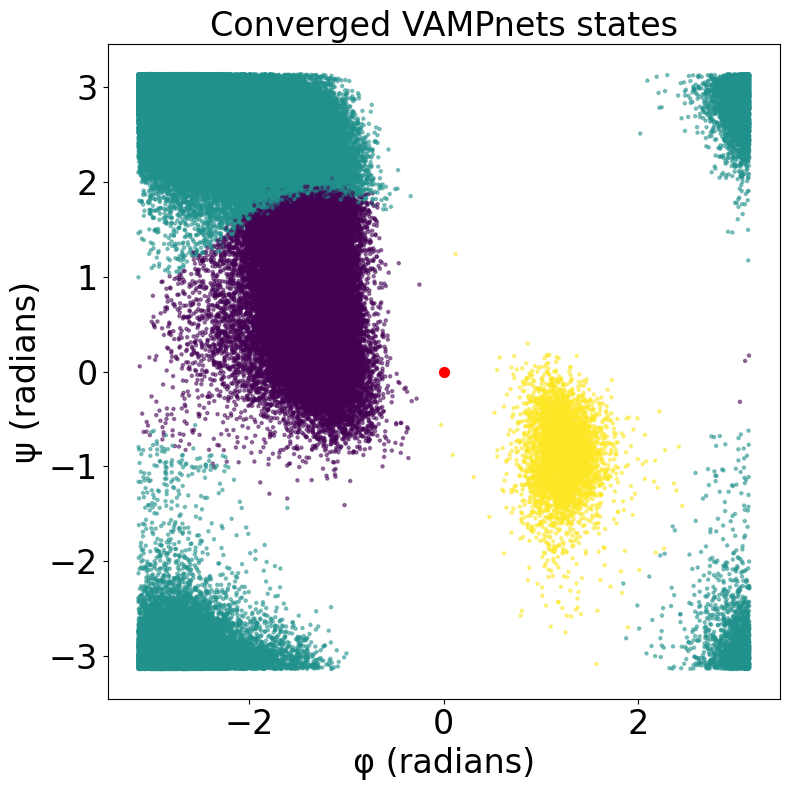

In [20]:
#@title
point = "B" #@param ["A", "B", "C"]
norm_threshold = 0.2 #@param {type:"number"}
custom = False # @param {"type":"boolean"}
phi = -1.2 # @param {"type":"number"}
psi = 0 # @param {"type":"number"}

if custom == True:
  angles = [phi, psi, 0, np.pi-0.2]
else:
  #state A
  if point == "A":
    angles = [-1.2,2,0,np.pi-0.2]
  elif point == "B":
  #state B
    angles = [0,0,0,np.pi-0.2]
  elif point == "C":
  #state C
    angles = [2.2,-1,0,np.pi-0.2]

angles_sin_cos = []
for i in range(4):
  angles_sin_cos.append(np.sin(angles[i]))
  angles_sin_cos.append(np.cos(angles[i]))

def point_picker(x_0,data, norm_threshold):
  found = False
  while found == False:
    diff = np.all(np.absolute(data - x_0) < norm_threshold,axis=1)
    ard = np.where(diff == True)[0]
    if ard.shape[0]>0:
      return data[ard[0],:], ard[0]
    else:
      norm_threshold *= 2
      print('Increasing threshold :' + str(norm_threshold))


x_0, x_0_index = point_picker(angles_sin_cos,traj, norm_threshold)
x_0_angles = [np.arctan2(x_0[0], x_0[1]), np.arctan2(x_0[2], x_0[3]), np.arctan2(x_0[4], x_0[5]), np.arctan2(x_0[6], x_0[7])]

print("Searching points near:: ", angles)
print("Found:: ", x_0_angles)

fig, ax = plt.subplots(figsize = (8,8))
state_probabilities = model.transform(traj)
assignments = state_probabilities.argmax(1)
ax.scatter(aladip_data[:, 0], aladip_data[:, 1], c=assignments[:], s=5, alpha=0.5)
ax.set_title('Converged VAMPnets states', fontsize = 24)
ax.set_xlabel('φ (radians)', fontsize = 24)
ax.set_ylabel('ψ (radians)', fontsize = 24)
ax.tick_params(axis='x', labelsize= 24)
ax.tick_params(axis='y', labelsize= 24)
ax.scatter(angles[0], angles[1], s = 50, color = 'red')
fig.tight_layout()

In [21]:
#@title TERP step 1
!python TERP_neighborhood_generator.py -seed 0 --progress_bar -input_sin sin.npy -input_cos cos.npy -num_samples 5000 -index $x_0_index

>>> Sin-cos data provided...
>>> Generating data...
100% 5000/5000 [00:00<00:00, 75719.85it/s]
>>> Data generation complete!
Files saved in :::  /content/DATA


In [22]:
#@title Fetch prediction for data generated in step 1
asd = np.load('DATA/make_prediction_sin.npy')
qwe = np.load('DATA/make_prediction_cos.npy')

iop = np.zeros((asd.shape[0], asd.shape[1]*2))
for i in range(iop.shape[1]):
  if i%2==0:
    iop[:,i] = asd[:,int(i/2)]
  else:
    iop[:,i] = qwe[:,int((i-1)/2)]

state_probabilities2 = model.transform(iop)

for ix, (mini, maxi) in enumerate(zip(np.min(state_probabilities2, axis=0),
                                      np.max(state_probabilities2, axis=0))):
    print(f"State {ix+1}: [{mini}, {maxi}]")

assignments2 = state_probabilities2.argmax(1)
np.save('DATA/prediction_neighborhood.npy', state_probabilities2)

State 1: [0.0039420826360583305, 0.6480026245117188]
State 2: [0.007452382240444422, 0.7950051426887512]
State 3: [0.059981606900691986, 0.9886054396629333]


In [24]:
#@title TERP step 2
!python TERP_optimizer_01.py -TERP_input DATA/TERP_sin_cos.npy -blackbox_prediction DATA/prediction_neighborhood.npy

----------------------------------------------------------------------------------------------------
11-01-24 18:15:32 initialization  INFO     Starting TERP...
----------------------------------------------------------------------------------------------------
11-01-24 18:15:32 initialization  INFO     Input data read successful ...
11-01-24 18:15:32 initialization  WARNING  explain_class not provided, defaulting to class with maximum predictiion probability :: 0
11-01-24 18:15:32 initialization  WARNING  Cutoff not provided. Defaulting to :: 25
11-01-24 18:15:32 initialization  INFO     No distance flag provided. Performing 1-d LDA projection to compute similarity measure!
11-01-24 18:15:32 initialization  WARNING  Top 25 features selected with weight coverage :: 1.0000000000000002!!
11-01-24 18:15:32 initialization  INFO     Selected the following 4 out of (4) features to form a feature sub-space ::
11-01-24 18:15:32 initialization  INFO     [0, 2, 3, 1]


In [25]:
#@title TERP step 3
!python TERP_neighborhood_generator.py -seed 0 --progress_bar  -input_sin sin.npy -input_cos cos.npy -num_samples 5000 -index $x_0_index -selected_features TERP_results/selected_features.npy

>>> Sin-cos data provided...
>>> Generating data...
100% 5000/5000 [00:00<00:00, 72793.51it/s]
>>> Data generation complete!
Files saved in :::  /content/DATA_2


In [26]:
#@title Fetch prediction for data generated in step 3
asd = np.load('DATA_2/make_prediction_sin.npy')
qwe = np.load('DATA_2/make_prediction_cos.npy')

iop = np.zeros((asd.shape[0], asd.shape[1]*2))
for i in range(iop.shape[1]):
  if i%2==0:
    iop[:,i] = asd[:,int(i/2)]
  else:
    iop[:,i] = qwe[:,int((i-1)/2)]

state_probabilities3 = model.transform(iop)

for ix, (mini, maxi) in enumerate(zip(np.min(state_probabilities3, axis=0),
                                      np.max(state_probabilities3, axis=0))):
    print(f"State {ix+1}: [{mini}, {maxi}]")

assignments3 = state_probabilities3.argmax(1)
np.save('DATA_2/prediction_neighborhood2.npy', state_probabilities3)

State 1: [0.0039420826360583305, 0.6480026245117188]
State 2: [0.007452382240444422, 0.7950051426887512]
State 3: [0.059981606900691986, 0.9886054396629333]


In [27]:
#@title TERP step 4
!python TERP_optimizer_02.py -TERP_input DATA_2/TERP_sin_cos.npy -blackbox_prediction DATA_2/prediction_neighborhood2.npy -selected_features TERP_results/selected_features.npy

----------------------------------------------------------------------------------------------------
11-01-24 18:16:29 initialization  INFO     Starting TERP...
----------------------------------------------------------------------------------------------------
11-01-24 18:16:29 initialization  INFO     Input data read successful ...
11-01-24 18:16:29 initialization  WARNING  explain_class not provided, defaulting to class with maximum predictiion probability :: 0
11-01-24 18:16:29 initialization  INFO     No distance flag provided. Performing 1-d LDA projection to compute similarity measure!
11-01-24 18:16:29 initialization  INFO     Feature selection results read successful!
11-01-24 18:16:29 initialization  INFO     Similarity computation complete...
----------------------------------------------------------------------------------------------------
Number of models constructed:: 100% 4/4 [00:00<00:00, 25.67it/s]
11-01-24 18:16:29 TERP_SGD_step_02 INFO     Analysis complete! Computa

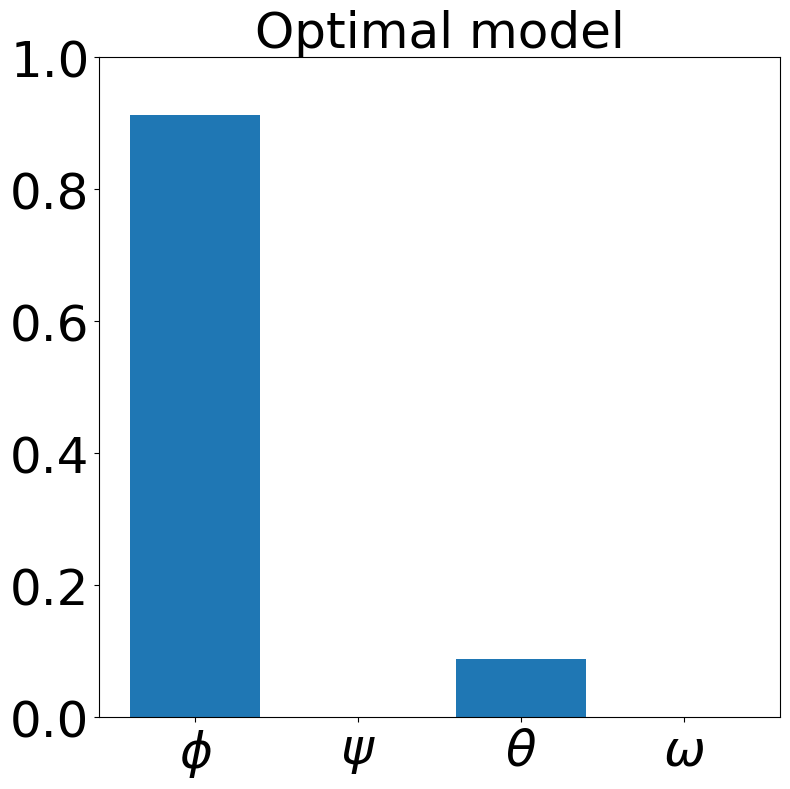

In [28]:
# @title Load TERP_results_2/optimal_feature_weights.npy and plot weights for the optimally chosen model
######################################
# Analysis
######################################
weights = np.load('TERP_results_2/optimal_feature_weights.npy')

fig, ax = plt.subplots(figsize = (8,8))
names = [r'$\phi$', r'$\psi$', r'$\theta$', r'$\omega$']
ax.bar(np.arange(4), weights)
ax.tick_params(axis='both', which='major', labelsize=36)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xticks(np.arange(4))
ax.set_xticklabels(names)
ax.set_ylim(0,1)
ax.set_title('Optimal model', fontsize = 36)
fig.tight_layout()

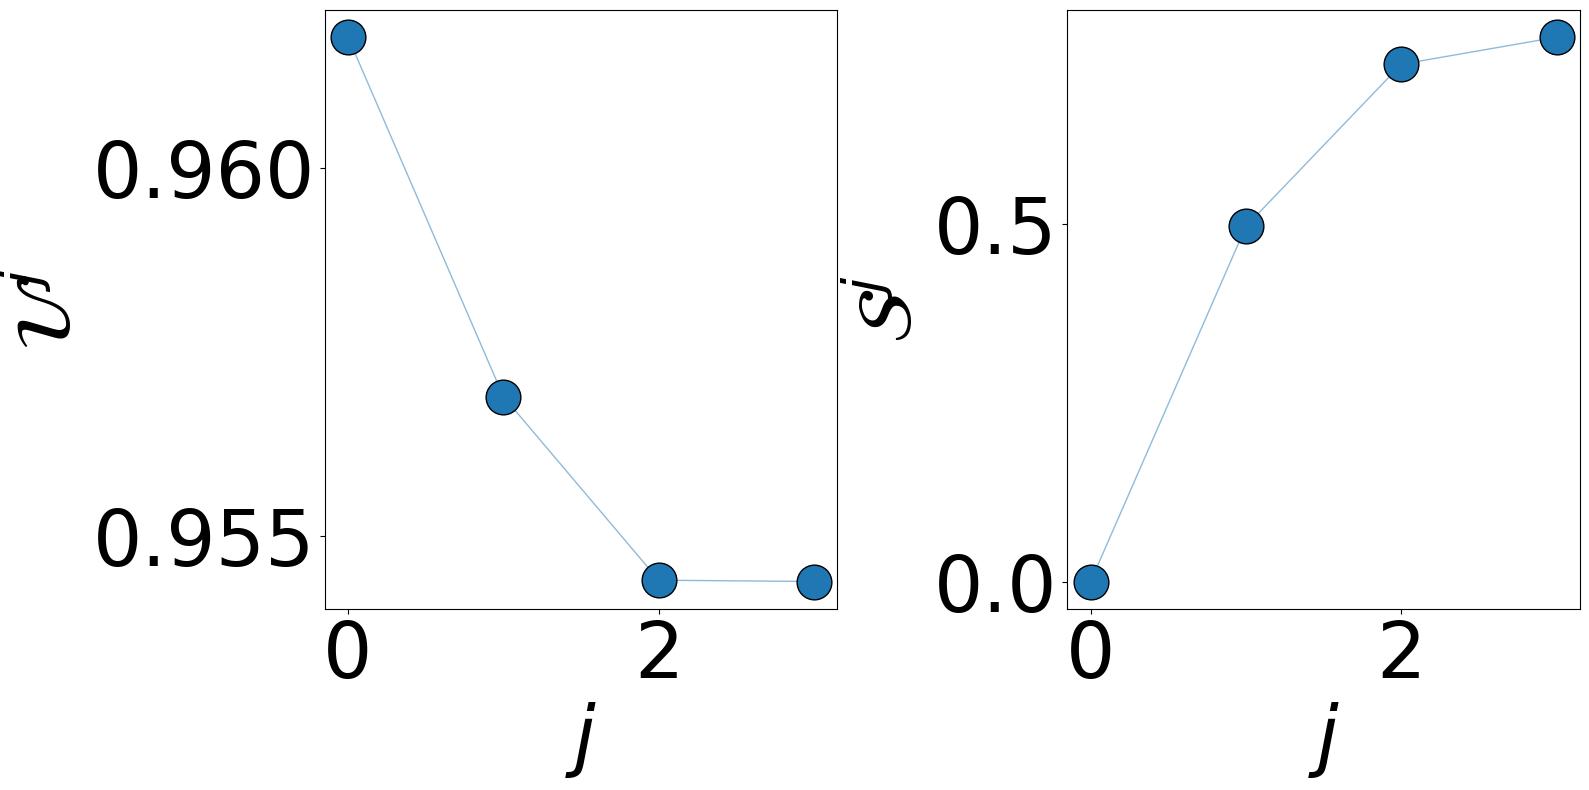

In [44]:
# @title Load TERP_results_2/unfaithfulness_scores_final.npy and TERP_results_2/interpretation_entropy_final.npy for plotting U(j), S(j)
U = np.load('TERP_results_2/unfaithfulness_scores_final.npy')
S = np.load('TERP_results_2/interpretation_entropy_final.npy')

fig, ax = plt.subplots(1, 2, figsize = (16, 8))

u_ultra = U
s_ultra = S

ax[0].plot(U, color = 'tab:blue', lw = 1, alpha = 0.5)
ax[0].plot(U,'o', markersize = 25, markeredgecolor = 'k', label = r'$\mathcal{U}_k$')
ax[0].set_ylabel(r'$\mathcal{U}^j$', fontsize = 56)
ax[0].set_xlabel(r'$j$', fontsize = 56)

ax[0].tick_params(axis='both', which='major', labelsize=56)
ax[0].tick_params(axis='both', which='minor', labelsize=8)

ax[1].plot(S, color = 'tab:blue', lw = 1, alpha = 0.5)
ax[1].plot(S,'o', markersize = 25, markeredgecolor = 'k', label = r'$\mathcal{S}_k$')
ax[1].set_ylabel(r'$\mathcal{S}^j$', fontsize = 56)
ax[1].set_xlabel(r'$j$', fontsize = 56)

ax[1].tick_params(axis='both', which='major', labelsize=56)
ax[1].tick_params(axis='both', which='minor', labelsize=8)
fig.tight_layout()

Sanity check :  3


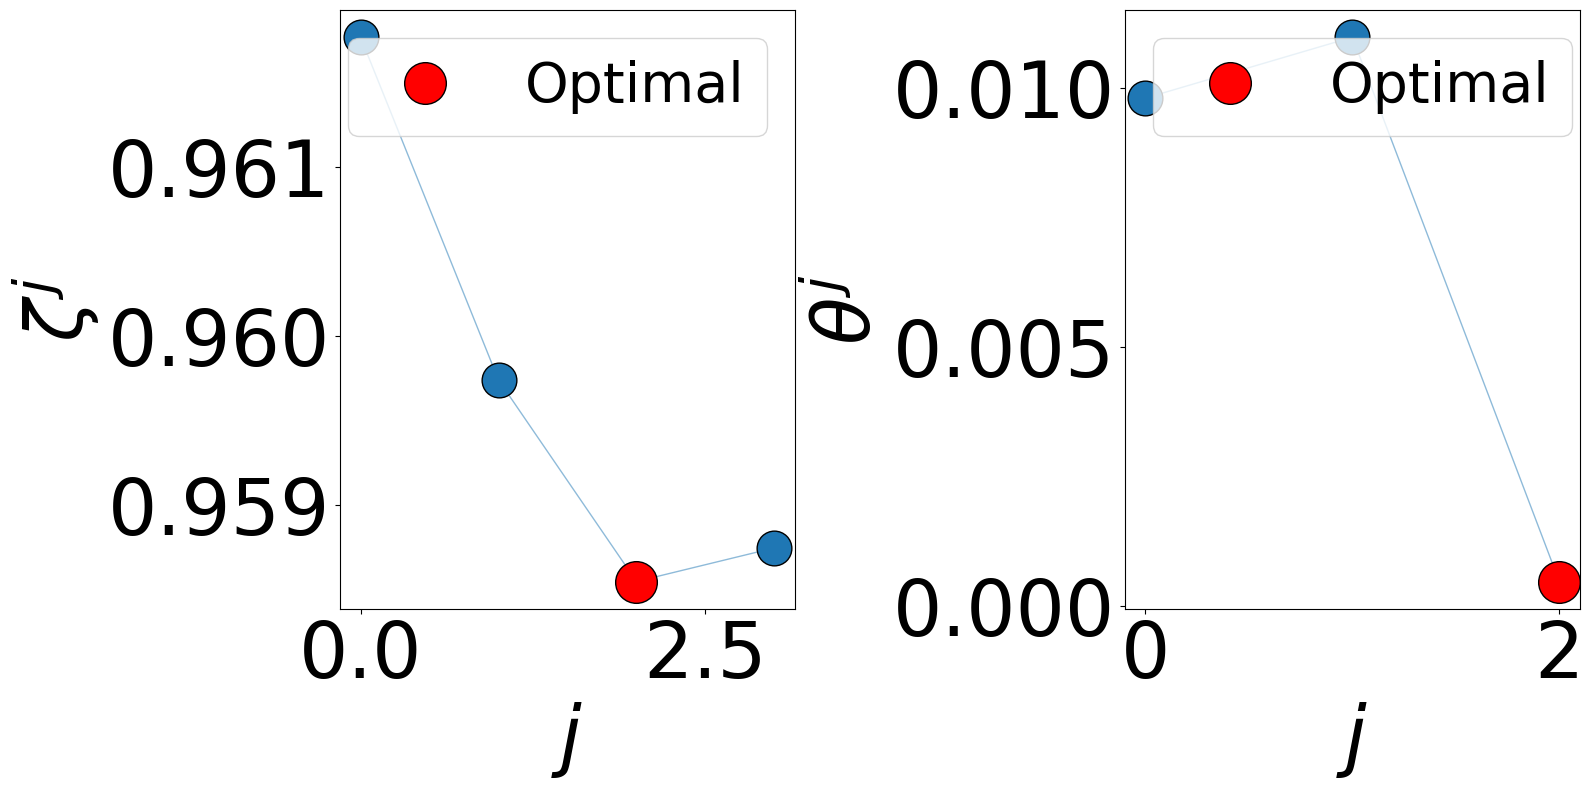

In [45]:
# @title Load TERP_results_2/charac_theta.npy and TERP_results_2/range_theta.npy for plotting ζ(j), θ(j)
T = np.load('TERP_results_2/charac_theta.npy')
T_range = np.load('TERP_results_2/range_theta.npy')

stable_model = np.argmin(T_range) + 2 # +2 takes care of indices
stable_T = (T[stable_model - 1] + T[stable_model - 2])/2


#print('Most stable model at k :: ', stable_model, ' at temperature :: ', "{:10.2f}".format(stable_T))

fig, ax = plt.subplots(1, 2, figsize = (16,8))

ax[0].plot(stable_T*S+U, color = 'tab:blue', lw = 1, alpha = 0.5)
ax[0].plot(stable_T*S+U,'o', markersize = 25, markeredgecolor = 'k')
ax[0].plot(stable_model-1, (stable_T*S+U)[stable_model-1], 'o',color = 'red', markersize = 30, markeredgecolor = 'k', label = 'Optimal')
z_ultra = stable_T*S+U

#ax.set_ylim(0,1)
ax[0].set_ylabel(r'$\zeta^j$', fontsize = 56)
ax[0].set_xlabel(r'$j$', fontsize = 56)
ax[0].tick_params(axis='both', which='major', labelsize=56)
ax[0].tick_params(axis='both', which='minor', labelsize=8)
ax[0].legend(fontsize = 40)


ax[1].plot(T, color = 'tab:blue', lw = 1, alpha = 0.5)
ax[1].plot(T,'o', markersize = 25, markeredgecolor = 'k')
t_ultra = T
print('Sanity check : ', np.argmin(stable_T*S+U)+1)
ax[1].set_ylabel(r'$\theta^j$', fontsize = 56)

ax[1].plot(stable_model-1, T[stable_model-1], 'o',color = 'red', markersize = 30, markeredgecolor = 'k', label = 'Optimal')
ax[1].set_xlabel(r'$j$', fontsize = 56)
ax[1].tick_params(axis='both', which='major', labelsize=56)
ax[1].tick_params(axis='both', which='minor', labelsize=8)
ax[1].legend(fontsize = 40)
fig.tight_layout()



*   Perturbation scheme for different data types have been carefully considered (numerical, periodic, categorical, sin/cos, images)
*    Similarity metric is meaningful

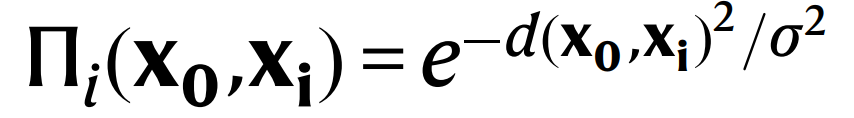

  


TERP builds linear models using number of dimensions ::  4


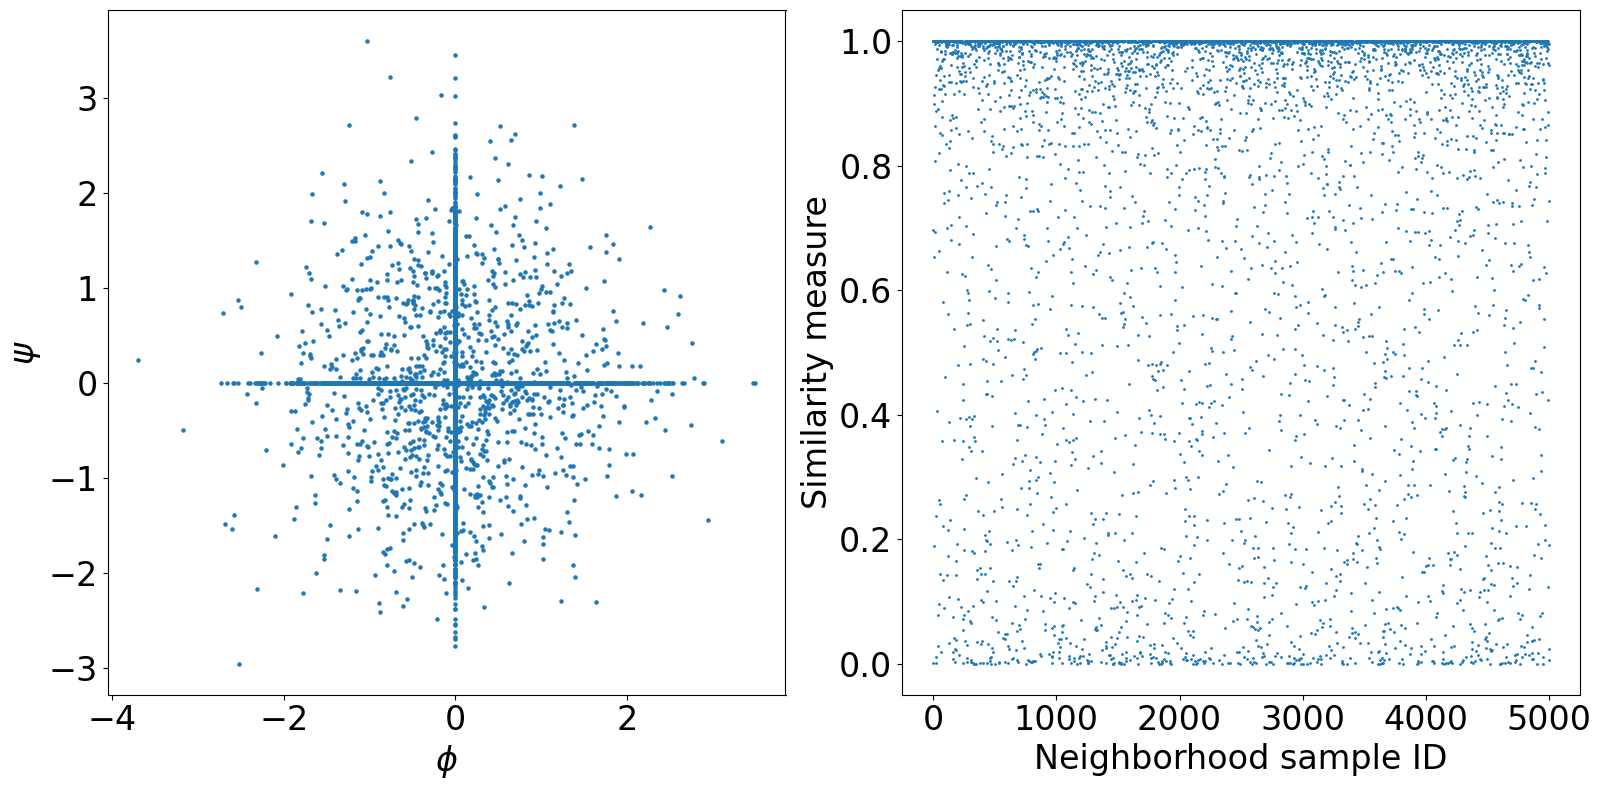

In [39]:
# @title
t1 = np.load('DATA_2/TERP_sin_cos.npy')
t2 = np.load('TERP_results_2/neighborhood_similarity_final.npy')

print('TERP builds linear models using number of dimensions :: ', t1.shape[1])

fig, ax = plt.subplots(1, 2, figsize = (16,8))
ax[0].scatter(t1[:, 0], t1[:,1], s = 5)
ax[1].plot(t2, 'o', markersize = 1)

ax[0].set_ylabel(r'$\psi$', fontsize = 24)
ax[0].set_xlabel(r'$\phi$', fontsize = 24)
ax[0].tick_params(axis='both', which='major', labelsize=24)
ax[0].tick_params(axis='both', which='minor', labelsize=8)

ax[1].set_xlabel(r'Neighborhood sample ID', fontsize = 24)
ax[1].set_ylabel(r'Similarity measure', fontsize = 24)
ax[1].tick_params(axis='both', which='major', labelsize=24)
ax[1].tick_params(axis='both', which='minor', labelsize=8)

fig.tight_layout()

**Try**  


*   Other combinations of coefficients when defining linear model
*   Custom (phi, psi) values to see feature importance attribution for alanine dipeptide in vaccuum

